<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">Identificación de huellas de calzado a partir de imágenes con redes neuronales convolucionales </p>
<p style="margin: 0; text-align:right;">MU Ingeniería Computacional y Matemática / Área de Inteligencia Artificial</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Laura Rivera Sanchez</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>



# Identificación de huellas de calzado a partir de imágenes con redes neuronales convolucionales 

El objetivo de este apartado es, a parte de la creación y entrenamiento de un red neuronal capaz de determinar la marca de calzado de una huella a partir de los datos disponibles. Se realizan diferentes experimentos con diferentes parámetros y procesos para analizar los resultados y poder concluir si éstas pueden dar un resultado satisfactorio.

Con este proyecto se quiere dar respuesta a las siguientes preguntas o hipótesis mediante los experimentos:
1.	¿Qué preprocesado de imágenes funciona mejor?
2.	¿Utilizar más epochs, resulta siempre en mejor resultado?
3.	¿Un mayor tamaño de las imágenes utilizadas, resulta en un mejor resultado? (En otro cuaderno)
4.	¿Cuál es el mínimo de muestras por marcas aceptable para el modelo?




In [2]:
#librerias necesarias:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import matplotlib.pyplot as plt
from PIL import Image
import os
import random
import skimage
import cv2 as cv
import pickle
from datetime import datetime


In [3]:
#En caso de utilizar google colab:
#from google.colab import drive
#drive.mount('/content/gdrive')

# Lectura y análisis de los conjuntos de datos






## Base de datos 2d FootWear con información de marca

Base de datos extraída de: https://iastate.figshare.com/articles/figure/2D_Footwear_outsole_impressions/11624073/1

https://www.sciencedirect.com/science/article/pii/S2352340920304029?via%3Dihub

In [4]:
def unzipImages(folder='images'):
    with ZipFile('data/2dFootwear/Part1.zip', 'r') as zipObj:
      zipObj.extractall(folder)

    with ZipFile('data/2dFootwear/Part2.zip', 'r') as zipObj:
      zipObj.extractall(folder)
    with ZipFile('data/2dFootwear/Part3.zip', 'r') as zipObj:
      zipObj.extractall(folder)

    with ZipFile('data/2dFootwear/Part4.zip', 'r') as zipObj:
      zipObj.extractall(folder)

    with ZipFile('data/2dFootwear/Part5.zip', 'r') as zipObj:
      zipObj.extractall(folder)

In [5]:
if not os.path.isdir("images"):
    unzipImages("images")

### Análisis de los datos 2d Footwear

Consiste en 1500 imágenes de la huella de 150 pares de zapatos de 28 individuos diferentes. Además, se dispone de 62 marcas de calzado diferentes, y las que más aparecen son Nike, Asics y Adidas. Por último, existen 70 registros de calzado de mujer y 80 de hombre.

In [6]:
df = pd.read_csv('data/2dFootwear/Data-information.csv', delimiter=';')
df['Brand'] = df['Brand'].str.strip() #eliminar espacios en blanco

X_files = df['ID'].values.tolist()
brands = df['Brand'].values.tolist()

values_brand, counts_brand = np.unique(brands, return_counts=True)
print('Tag example:',X_files[0]) #nomenclatura 
print('Nº lines:',len(X_files)) #lineas en el csv
individuals, count_ind = np.unique(df['ID'].str[:3], return_counts=True)
print('Nº different people:',len(individuals)) #diferentes individuos de la muestra
num_classes = len(values_brand) #se guarda porque será necesario para crear el modelo
print('Nº of different brands: %d' %num_classes) #marcas diferentes
print(values_brand) #Listado de marcas únicas



Tag example: 001_01
Nº lines: 150
Nº different people: 28
Nº of different brands: 60
['Adidas' 'Airspeed' 'Airwalk' 'Aldo' 'American Eagle' 'Arizona' 'Asics'
 'BAGO' 'BASS' 'Birkenstock' 'Brooks' 'CalvinKlain' 'Champion' 'Clarks'
 'Columbus' 'Converse' 'Cooeli' 'Court classic' 'Dansko' 'Deer Stags'
 'Dockers' 'Ecco' 'Elcanto' 'Fadedglory' 'Feiyue' 'Fila' 'G.H.Bass&Co'
 'Guho' 'HeyBear' 'K-swiss' 'Keen' 'Landya' 'Namuhana' 'Newbalance' 'Nike'
 'Ninewest' 'None' 'OP' 'Ofem' 'Prospecs' 'Puma' 'Robin' 'Saucony'
 'Shoedy' 'Shoopen' 'Simply vera' 'Skechers' 'Soma' 'Sonoma' 'Sorel'
 'Sperry' 'Stone' 'Sugar' 'T2R' 'Teva' 'Truesoft' 'Under Amour' 'Vans'
 'Vibram' 'Yonex']


A continuación, el histograma con el número de muestras según género, en este caso hay 70 muestras de mujeres y 80 de hombres.

(array([71.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 79.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

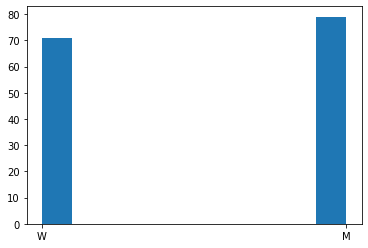

In [7]:
plt.hist(df['Gender'])

Por último, se muestran las cinco marcas que más aparecen en el conjunto de datos. \
Además se seleccionan esas marcas que aparecen minimo X veces en la muestra (X=5 por defecto), para crear un subconjunto de datos que elimine las marcas con una única muestra y comprobar en los siguientes casos si influye en el resultado.


           x   y
0     Adidas  12
6      Asics  13
15  Converse   7
34      Nike  24
42   Saucony   6
46  Skechers   8
50    Sperry   7
Brands with at least 5 samples: 7
Brands with only 1 register: 52


<AxesSubplot: xlabel='x'>

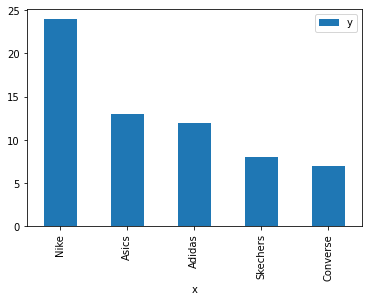

In [8]:

def filterMinSamples(data, minSamples, deleteNone=True):
    if deleteNone == True:
        data=data[data['x']!="None"] #eliminar marca = "None"

    dataone=data[data['y']<minSamples] #marcas con pocas muestras
    if deleteNone == True:
        data=data[data['y']>=minSamples] #marcas con minimo "minSamples" muestras
    else:
        data.loc[data['y']<minSamples, 'x'] ="None"
        values_brand, counts_brand = np.unique(data['x'], return_counts=True)
        data = pd.DataFrame({'x':values_brand, 'y':counts_brand}) 
        #data = data.groupby('x').agg(y=('y','sum'))
    print(data)
    num_classes=len(data)
    print('Brands with at least '+str(minSamples)+' samples: %d' %num_classes) 
    print('Brands with only 1 register: %d' %len(dataone)) 
    return data, dataone

dfbrandall = pd.DataFrame({'x':values_brand, 'y':counts_brand}) 

dfbrand, dfbrandone = filterMinSamples(dfbrandall, 5)

num_classes=len(dfbrand)
dfbrand = dfbrand.sort_values('y', ascending = False) #ordenar descendientemente

# mostrar las 5 marcas que más aparecen en el conjunto de datos
dfbrand.head(5).plot('x', 'y', kind='bar') #mostrar gráfica



In [11]:
def crop_jpeg(crop_size, imgPath):
    dir_list = os.listdir("./"+imgPath)
    for f in dir_list:
        im = Image.open("./"+imgPath+"/"+f)
        h,w,c = im.shape
        im3 = im2.crop((crop_size,crop_size,h-(crop_size*2),w-(crop_size*2))) #Quitar marco medidor

def get_images_full_to_jpeg(imgPath):
  dir_list = os.listdir("./"+imgPath)
  result = []

  for f in dir_list:

    im = Image.open("./"+imgPath+"/"+f)
    im.save("./"+imgPath+"/"+f[0:-4]+'jpeg')
    
    result.append(f[0:-4]+'jpeg')
    os.remove("./"+imgPath+"/"+f)

  print('Nº files:',len(result))
  return result


def get_images_to_jpeg(imgPath):
  dir_list = os.listdir("./"+imgPath)
  result = []

  for f in dir_list:

    im = Image.open("./"+imgPath+"/"+f)
    im2=im.resize((400,912))
    im3 = im2.crop((40,40,320,872)) #Quitar marco medidor
    im3.save("./"+imgPath+"/"+f[0:-4]+'jpeg')
    
    result.append(f[0:-4]+'jpeg')
    os.remove("./"+imgPath+"/"+f)

  print('Nº files:',len(result))
  return result

def get_images(imgPath):
  dir_list = os.listdir("./"+imgPath)
  result = []
  for f in dir_list: 
    if "jpeg" in f:
        result.append(f)


  print('Nº files:',len(result))
  return result

In [12]:
# Get the list of all files in /images and convert to jpeg
#shoeFiles = get_images_to_jpeg("images") #la primera vez para convertir las imágenes
shoeFiles = get_images("images")

Nº files: 1500


### Visualización de imágenes

Se ha creado la función *plot_image* que permite la visualización de las imágenes de cualquiera de las dos bases de datos.

Parámetros:\
*imgPath*: carpeta donde estan las imágenes \
*fileNames*: array con los nombres de los ficheros a mostrar


In [13]:

import skimage
def plot_image(imgPath, fileNames):
  for i in range(len(fileNames)):
    filename = fileNames[i]
    img = skimage.io.imread(imgPath+filename)
   
    plt.figure()
    plt.title(str(img.shape)+" , "+str(img.dtype))
    plt.imshow(img)
  print(fileNames)
  plt.show()

def plot_image2(img):

    plt.figure()
    plt.title(str(img.shape)+" , "+str(img.dtype))
    plt.imshow(img)

    plt.show()
def plot_image_grey(img):

    plt.figure()
    plt.title(str(img.shape)+" , "+str(img.dtype))
    plt.imshow(img, cmap='gray')

    plt.show()

A continuación, se muestra una imagen aleatória de cada uno de los 3 datasets del proyecto:

['025_02_R_03.jpeg']


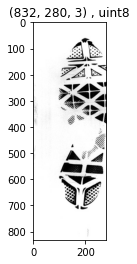

In [14]:
plot_image("images/",random.choices(shoeFiles,k=1))

## División de los datos

Para la división de los datos se ha utilizado la funcióon train_test_split dos veces, primero para dividir entre el 80% de train y el 20% de test y después para extraer el equivalente al 10% para la validación. 

De esta manera se dispone de 70% train, 20% test y 10% validación.


Antes de dividir los datos de la base de datos 2d Footwear, se ha formateado la tabla ya que actualmente solo muestra la información de marca según el calzado del usuario, pero no contiene el nombre de la imagen, se ha creado la siguiente función para que el conjunto de datos contenga dos columnas (X:fichero, y:marca)

In [15]:
def filesWithBrand(shoeFiles):
  files = []
  brands = []
  for image in shoeFiles:
    files.append(image) #filename
    person = df[df['ID'].str[:6]==image[:6]]  #persona+contador de calzado
    brands.append(person['Brand'].iloc[0])

  return pd.DataFrame({'X':files, 'y':brands}) 

def filterBrands(data, one, deleteNone=True):
    #dfbrandone creado antes con las marcas que no cumplen.
  
    if not one.empty:
        df_shoe_brand=data[~data['y'].isin(one['x'].to_numpy())]
    else: #Nothing to remove
        df_shoe_brand = data
    
    if deleteNone == True:
        df_shoe_brand=df_shoe_brand[df_shoe_brand['y']!="None"]
        
    df_shoe_brand['factor_brand'] = pd.Categorical(pd.factorize(df_shoe_brand['y'])[0].astype(np.float32))
    
    return df_shoe_brand

df_shoe_brand_all = filesWithBrand(shoeFiles) #contiene todas las muestras

#eliminar aquellas marcas que no aparecen mínimo en "minSample" muestras 
df_shoe_brand = filterBrands(df_shoe_brand_all,dfbrandone)
print(df_shoe_brand)
#número de marcas con 5 o más muestras:
print('Nº of brands: %d' %num_classes)

                     X         y factor_brand
3     009_08_R_05.jpeg     Asics          0.0
8     010_01_L_01.jpeg  Skechers          1.0
13    025_05_R_01.jpeg     Asics          0.0
15    020_03_R_03.jpeg    Sperry          2.0
17    011_03_L_04.jpeg    Adidas          3.0
...                ...       ...          ...
1490  020_02_L_01.jpeg  Skechers          1.0
1493  011_01_R_04.jpeg    Adidas          3.0
1494  026_07_L_03.jpeg   Saucony          6.0
1496  018_04_R_02.jpeg    Sperry          2.0
1499  025_03_L_04.jpeg      Nike          4.0

[770 rows x 3 columns]
Nº of brands: 7


In [16]:
def checkBalancedSample(train, test, val):
    checkTest = False
    checkVal = False
    
    #Comprobar si existen en train
    test_in = test.y.isin(train.y).astype(int)
    val_in=val.y.isin(train.y).astype(int)

    #Comprobar que existen todos (todo 1)  
    if all(x==1 for x in test_in):
        checkTest = True
    if all(x==1 for x in val_in):
        checkVal = True
    #Devuelve True si en test y val aparecen marcas que existen en train:
    if checkTest and checkVal:
        return True
    return False

In [17]:
from sklearn.model_selection import train_test_split
def  split_datafiles(df):

  X_train, X_test = train_test_split(df, test_size=0.2 , random_state=random.randint(0,32),shuffle=True)

  X_train, X_val = train_test_split(X_train ,test_size=0.14, random_state=random.randint(0,32),shuffle=True) # 0.14 x 0.7 = 0.1
  return X_train,  X_test ,X_val

#Dividir conjunto de datos:
#shoes_train, shoes_test, shoes_val = split_datafiles(df)
shoes_train, shoes_test, shoes_val = split_datafiles(df_shoe_brand)

while checkBalancedSample(shoes_train, shoes_test, shoes_val) == False:
    shoes_train, shoes_test, shoes_val = split_datafiles(df_shoe_brand)
    

# Clasificadores

En este apartado, primero se utilizan diferentes clasificadores para comparar, posteriormente, su resultado con el de la red neuronal convolucional propuesta.

## Extracción de características

La extracción de características es el proceso de recuperar los datos más importantes de los datos sin procesar. La extracción de características es encontrar el conjunto de parámetros que definen la forma de una imagen de manera precisa y única.

Para la extracción de características se utiliza la técnica Bag of Features, que extrae N características de las imágenes utilizando los descriptores SIFT (Scale Invariant Feature Transform).

Existen diferentes algoritmos de extracción de caraterísticas y para este proyecto se escoge utilizar SIFT ya que KAZE y ORB tienen cuenta las rotaciones y en este caso no sería necesario, ya que todas las muestras se toman con la misma metodologia.
 
Se hace uso de la librería OpenCV, de uso libre y con funcionalidades de visión por computador.


In [87]:
!pip install opencv-contrib-python==4.4.0.44 


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [92]:
#extrae y calcula los descriptores SIFT para el conjunto de imágenes enviado
def extractSIFT(input_files):
    all_features_dict = {}
    feature_extractor = cv.SIFT.create()
    for i, fname in enumerate(input_files):
        rgb = cv.cvtColor(cv.imread("images/"+fname), cv2.COLOR_BGR2RGB)
        gray = cv.cvtColor(rgb, cv.COLOR_RGB2GRAY)
        kp, desc = feature_extractor.detectAndCompute(gray, None)
        all_features_dict[fname] = desc
    return all_features_dict

In [93]:
#Esta función extrae las características de cada categoria (marca)
#input: listado de categorias (marcas), listado de ficheros, marca de cada fichero
#output: lista ficheros, lista categorias, lista de características
def getFiles(cat_list, X_files, y_values):
  all_files = []
  all_files_labels = {}
  all_features = {}
  cat_indexes= []
  cat_files = []
  cat_features = []

  #values_train contiene el listado de categorias sin repeticiones 
  for cat, label in zip(cat_list, range(len(cat_list))):
      
      #primero buscar los indices en el listado de cada categoria (dentro bucle)
      cat_indexes = [i for i,x in enumerate(y_values) if x == cat]
      
      #como se saben las posiciones, se cogen esas imagenes de esa categoria:
      cat_files = [X_files.iloc[i] for i in cat_indexes]
      cat_features = extractSIFT(cat_files)
      all_files = all_files + cat_files
      all_features.update(cat_features)
      for i in cat_files:
          all_files_labels[i] = label
  return all_files, all_files_labels, all_features

In [94]:


def getFilesBySubset(subset, tipo):
    #values_brand= np.unique(subset['y']) #listado marcas únicas que aparecen en subconjunto TRAIN

    if os.path.exists("saved/all_files_nonone2_"+tipo+".pkl"):
        with open('saved/all_files_nonone_'+tipo+'.pkl', 'rb') as fp:
            all_files = pickle.load(fp)
        with open('saved/all_files_nonone_labels_'+tipo+'.pkl', 'rb') as fp:
            all_files_labels = pickle.load(fp)
        with open('saved/all_features_nonone_'+tipo+'.pkl', 'rb') as fp:
            all_features = pickle.load(fp)
        #all_files_train = np.loadtxt('saved/all_files_train.txt')
        #all_files_labels_train = np.loadtxt('saved/all_files_labels_train.txt')
        #all_features_train = np.loadtxt('saved/all_features_train.txt')
    else:
        all_files, all_files_labels, all_features=getFiles(values_brand,subset['X'],subset['y'])

    return all_files, all_files_labels, all_features


In [95]:
values_brand= np.unique(df_shoe_brand['y']) #listado marcas únicas que aparecen en subconjunto TRAIN

all_files_train, all_files_labels_train, all_features_train=getFilesBySubset(shoes_train, "train")
#Este proceso tarda 40 minutos aproximadamente, por eso se guarda en un fichero para agilizar las pruebas

In [83]:

if not os.path.exists("saved/all_files_nonone_train.pkl"):
    with open('saved/all_files_nonone_train.pkl', 'wb') as fp:
        pickle.dump(all_files_train, fp)
    with open('saved/all_files_labels_nonone_train.pkl', 'wb') as fp:
        pickle.dump(all_files_labels_train, fp)
    with open('saved/all_features_nonone_train.pkl', 'wb') as fp:
        pickle.dump(all_features_train, fp)
        

A continuación un ejemplo de la matriz de características y la impresión de la imagen con los puntos puntos de interés detectados.

In [96]:
#guarda la primera imagen  con los puntos de interés
img = cv.imread("images/"+all_files_train[0])
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

features = cv2.SIFT_create()
keypoints = features.detect(gray, None)

img2=cv.drawKeypoints(gray,keypoints,0,(0,0,255), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv.imwrite('results/'+all_files_train[0], img2)



True

In [97]:
#Se crea el Bag of Features con un diccionario de tamaño 75:
dictionarySize =75
if not os.path.exists("saved/bow_dict_nonone.pkl"):
    
    BOW = cv.BOWKMeansTrainer(dictionarySize)

    for feat in all_features_train:
        BOW.add(all_features_train[feat])
    dictionary = BOW.cluster()
else:
    with open('saved/bow_dict_nonone.pkl', 'rb') as fp:
        dictionary = pickle.load(fp)
print(dictionary.shape)
print(all_features_train[all_files_train[0]].shape) #subdivisión de train: shoes_train

(75, 128)
(1024, 128)


In [98]:
import pickle
if not os.path.exists("saved/bow_dict_nonone.pkl"):
    with open('saved/bow_dict_nonone.pkl', 'wb') as fp:
        pickle.dump(dictionary, fp)
        print('BOW dictionary saved successfully to file')
        
#Como se trata de un proceso que toma bastante tiempo, también se ha decidido guardar el resultado en un fichero para futuras ejecuciones

In [99]:
def getFeatures(all_files, all_features, all_files_labels):
  X = np.empty((len(all_files),dictionarySize))
  y = np.empty((len(all_files),))
  all_features_BOW = {}

  count = 0
  for filename in all_files:
      desc_query = all_features[filename]
      matches = matcher.match(desc_query,dictionary)
      train_idxs = []
      for j in range(len(matches)):
        train_idxs.append(matches[j].trainIdx)
      hist, bin_edges = histogram(train_idxs, bins=range(dictionarySize+1))
      all_features_BOW[filename] = hist
      X[count,:] = hist
      y[count] = all_files_labels[filename]
      count = count + 1
  return X,y

In [100]:
from numpy import histogram
import numpy as np

#Comentario: A continuación se normaliza el numero de caracteristicas para que todas tengan la misma cantidad,
#ya que con el proceso anterior (BOW) es muy probable que las imagenes tengan numero de caracteristicas diferentes.

matcher = cv.BFMatcher(normType=cv.NORM_L2)

X, y = getFeatures(all_files_train, all_features_train, all_files_labels_train)


### Support Vector Machines (SVM)

Tiene como objetivo encontrar el hiperplano que clasifica claramente los puntos. Este hiperplano se calcula maximizando el margen de las instancias de entrenamiento en el espacio de destino.

In [101]:

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import GridSearchCV

X_train, X_test_t, y_train, y_test_t = train_test_split(X, y, test_size=0.3, random_state=0)

# Set the parameters by cross-validation
kernels =  ["rbf", "linear", "poly", "sigmoid"]
Cs= [1, 2,3,4, 5, 10, 20]


#Se utiliza GridSearchCV para identificar la mejor configuración de entre los diferentes kernel con diferentes
#valores de C.
clf = GridSearchCV(estimator=svm.SVC(), param_grid=dict(C=Cs, kernel=kernels),n_jobs=-1)
clf.fit(X_train, y_train)

print('Mejor configuración kernel=%s, c= %s con un score de %s' %(clf.best_estimator_.kernel, clf.best_estimator_.C, clf.best_score_))

Mejor configuración kernel=rbf, c= 20 con un score de 0.9783783783783784


In [102]:
#Ejecuto la configuración con mejor resultado kernel=rbf, c=20:

clf_train = svm.SVC(kernel='rbf', C=20).fit(X_train, y_train)
clf_train.score(X_test_t, y_test_t)

0.9811320754716981

### KNeighborsClassifier

Determina la clase de la información mirando los puntos cercanos. De manera que selecciona la clase (o grupo) que tiene más puntos de la instancia.

In [105]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=num_classes)
model.fit(X_train, y_train)
model.score(X_test_t, y_test_t)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:189: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


0.8679245283018868

### DecisionTreeClassifier

Las normas de clasificación se extraen construyendo un árbol de decisiones con los datos de entrenamiento. En cada nodo del árbol, se utiliza el atributo con mayor diferencia en entropía para dividir los datos.

In [107]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
model.score(X_test_t, y_test_t)

0.7547169811320755

# Objetivo 1: Predicción de la marca de calzado utilizando redes neuronales convolucionales 







## Red neuronal convolucional propuesta

En este caso los datos ya estan etiquetados, por lo que se puede crear un modelo para que entrene según esa etiqueta. 


*Es necesario transformar las etiquetas de marcas a numérico para el correcto funcionamiento del modelo. Paso realizado en los primeros pasos*





In [34]:
#Se ha creado un generador para añadir la aumentación de las imágenes
import torchvision.io
import torch
from tensorflow.keras.utils import Sequence
import torchvision.transforms as T
from torchvision.transforms import Resize
from skimage.io import imread
from skimage.util import img_as_float,random_noise
from skimage.transform import rotate
from skimage.color import rgb2gray
import numpy as np
import random
import os
from skimage import io
from skimage import transform, util



#función que elimina las filas y columnas en blanco:
def crop_image(gray, pixel_value=220):
    #gray = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    
    crop_rows = gray[~np.all(gray > pixel_value, axis=1), :]
    cropped_image = crop_rows[:, ~np.all(crop_rows > pixel_value, axis=0)]
    return cropped_image

def create_variation(theImage,doFlip,doNoise,doRotate):
  image = img_as_float(theImage)
  if doFlip==True:
    image = np.fliplr(image)
  if doNoise==True:
    image = util.random_noise(image)
  if doRotate==True:
    image = transform.rotate(image, random.randint(-45, 45),mode='symmetric')
  return image

class DataGenerator2dFootwear(Sequence):
    # Constructor. Input parameters are:
    # * fileNames   : List of sample file names
    # * doRandomize : If True, the provided file names are shuffled after each training epoch
    #                 and each image can be left unchanged, flipped, corrupted with
    #                 noise or rotated. 8 possible combinations is chosen randomly with equal probability.
    #                 If False, file names are not shuffled and each image is provided unchanged.
    # * imgPath     : Path to the images 
    # * batchSize   : Number of sample images and ground truth items in each batch
    def __init__(self,data, df_shoe_brand,doRandomize=False,imgPath='images', doGray=True,doBin=True, doCrop = True,batchSize=10):
        # Store parameters
        self.imgPath=imgPath
        self.fileNames=data.copy()
        self.batchSize=batchSize
        self.doRandomize=doRandomize
        self.df_shoe_brand=df_shoe_brand
        self.doGray=doGray
        self.doBin=doBin
        self.doCrop=doCrop
        # Get number of files (to avoid computing them later)
        self.numImages=len(data)
        # Shuffle them if required
        self.on_epoch_end()

    # Shuffle data if required
    def on_epoch_end(self):
        if self.doRandomize:
            random.shuffle(self.fileNames)

    # Returns the number of total batches
    def __len__(self):
        return int(np.ceil(float(self.numImages)/float(self.batchSize)))

    
    # Input  : theIndex - Index of the image to load within self.fileNames.
    # Output : theImage - Loaded (and possibly transformed) image. Must be
    #                     of float type with values within [0,1]
    #          theClass - Shoe brand
    def _load_image_(self,theIndex):

   
        file = self.fileNames[theIndex]  
        
        
        img = io.imread(self.imgPath+file)
        h,w,c = img.shape #guardar el shape por si se hace crop poder hacer el resize 
     
        if self.doGray:#escala de grises
            img = rgb2gray(img)
            #plot_image_grey(img)
        if self.doBin: #blanco y negro
            test_binary_high,img = cv.threshold(img,0, 255, cv2.THRESH_BINARY)
        if self.doCrop: #quitar columnas/filas blancas
            img = crop_image(img)
            img = cv2.resize(img, (h,w), interpolation = cv2.INTER_AREA)
        
        theImage = img_as_float(img) 
        
        theImage=theImage /255.0 #normalizar (quito rescaling del modelo)

        #añadir aumentación a las imágenes:
        if self.doRandomize:
          theImage=create_variation(img,random.choice([True, False]),random.choice([True, False]),random.choice([True, False])) 
        #else:
         # theImage=create_variation(img,False, False, False)

        #Buscar la imagen en el csv para extraer la Marca:
        person = self.df_shoe_brand[self.df_shoe_brand['X'].str[:6]==file[:6]]  #persona+contador de calzado
        theClass = person['factor_brand'].iloc[0]#self.classes[theIndex] #¿debe ser numérico o podría ser la etiqueta?
        return theImage,theClass

    # Provides the images,class batch
    # Batch format:
    # - X : The data. Numpy array of shape (bs,nr,nc,3)
    # - y : The ground truth. Numpy array of shape (bs,1)
    # Where nb=batch size, nr=num rows, nc=num cols
    def __getitem__(self,theIndex):
        X=[]
        y=[]
        bStart=max(theIndex*self.batchSize,0)
        bEnd=min((theIndex+1)*self.batchSize,self.numImages)
        for i in range(bStart,bEnd):
            [curImage,curGT]=self._load_image_(i)
            X.append(curImage)
            y.append(curGT)
        return np.array(X),np.array(y)
    
    


In [35]:
#Modelo con dropout:
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten, Softmax, Rescaling, Dropout
import tensorflow as tf

def createModelTest(color, n=num_classes):
    if color == True:
        shape = (280,832,3)
    else:
        shape = (280,832,1)
    model_test = models.Sequential([
      Conv2D(16, 3, padding='same', activation='relu', input_shape=shape),
      MaxPooling2D(),
      Conv2D(32, 3, padding='same', activation='relu'),
      MaxPooling2D(),
      Conv2D(64, 3, padding='same', activation='relu'),
      MaxPooling2D(),
      Flatten(),
      Dense(128, activation='relu'),
      Dropout(0.5),
      Dense(n, activation='softmax'),
      Flatten()
    ])
    return model_test




In [36]:
def createModelTestCustomShape(color,w,h):
    if color == True:
        shape = (w,h,3)
    else:
        shape = (w,h,1)
    model_test = models.Sequential([
      #Rescaling(1./255, input_shape=(280,832,3)),
      Conv2D(16, 3, padding='same', activation='relu', input_shape=shape),
      MaxPooling2D(),
      Conv2D(32, 3, padding='same', activation='relu'),
      MaxPooling2D(),
      Conv2D(64, 3, padding='same', activation='relu'),
      MaxPooling2D(),
      Flatten(),
      Dense(128, activation='relu'),
      Dropout(0.5),
      Dense(num_classes, activation='softmax'),
      Flatten()
      #Dense(num_classes,activation='softmax')
      # ,Flatten()
    ])
    return model_test

In [37]:

def plot_history(history):
# summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def plot_history_2(history):
    plt.plot(history.history['accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [38]:
def showResult(predicted, test, array):
    filename = test['X']
    img = skimage.io.imread("images/"+filename)
   
    plt.figure()
    plt.title(test['y']+" "+str(test['factor_brand']))
    plt.imshow(img)
    if array == True:
        print(predicted)
        sort_index = np.argsort(-predicted)
        print(sort_index)
    else:
        print(predicted)

    
  

In [39]:
#Calular porcentaje que aparecen en las 3 primera posiciones 
def getXfirstOk(predicted, test, x):
    sort_index = np.argsort(-predicted)
    if test['factor_brand'] in sort_index[:x]:
        return True
    return False
        

In [40]:

def checkAccuracyFirstPositions(predicted_y, shoes_test, x):
    total = len(predicted_y)
    ok = 0
    for i in range(total):
        if getXfirstOk(predicted_y[i],shoes_test.iloc[i],x):
            ok = ok+1

    print(ok)
    print(ok/total)


In [41]:
#Devuelve el % de veces que la marca se predijo con un porcentage >= minPercent
#Porcentaje de aceptación.
def checkBrandPercent(predicted_y, shoes_test, minPercent):
    total = len(predicted_y)
    ok = 0
    for i in range(total):
        #print(shoes_test['factor_brand'].iloc[i])
        #print(predicted_y[int(shoes_test['factor_brand'].iloc[i])])
        if predicted_y[0][int(shoes_test['factor_brand'].iloc[i])] >= minPercent: 
            ok = ok+1

    print(ok/total)


In [42]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix,ConfusionMatrixDisplay

def printConfMatrix(predicted, test, n ):
    sort_index = np.argsort(-predicted)
    cm = confusion_matrix(test['factor_brand'],[item[0] for item in sort_index])

    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = range(n))

    cm_display.plot()
    plt.show() 

In [43]:
def checkModel(modelTest, testGenerator, shoes_test, num_classes):
    predicted_y = modelTest.predict(testGenerator)
    print("Test evaluation:")
    print(modelTest.evaluate(testGenerator))
    print("% of correct brand in the first 3 positions:")
    checkAccuracyFirstPositions(predicted_y, shoes_test,3)
    print("% of brand predicted with percentage >= 0.25") #independent from position
    checkBrandPercent(predicted_y, shoes_test,0.25)
    print("% of brand predicted with percentage >= 0.5") 
    checkBrandPercent(predicted_y, shoes_test,0.5)
    print("% of brand predicted with percentage >= 0.75") 
    checkBrandPercent(predicted_y, shoes_test,0.75)
    print("Matriz de confusión:") 
    printConfMatrix(predicted_y,shoes_test, num_classes)

In [44]:
def executeModel(aumentation, gray, binary, crop, epoch):
   
    modelTest = createModelTest(not gray)
    
    modelTest.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
    
    #Configurar el preprocesado que se hará en las imágenes desntro del Generator.
    trainGenerator=DataGenerator2dFootwear(shoes_train['X'].tolist(),df_shoe_brand,aumentation, "images/", gray, binary, crop)
    testGenerator=DataGenerator2dFootwear(shoes_test['X'].tolist(),df_shoe_brand,False, "images/", gray, binary, crop)
    valGenerator=DataGenerator2dFootwear(shoes_val['X'].tolist(),df_shoe_brand,False, "images/", gray, binary, crop)
    print(" ")
    print('Training model with aumentation:'+str(aumentation)+', gray:'+str(gray)+', binary:'+str(binary)+', crop:'+str(crop)+' and epochs = '+str(epoch))
    trainHistory = modelTest.fit(trainGenerator,validation_data=valGenerator, epochs=epoch)
    
    plot_history(trainHistory)
    
    checkModel(modelTest, testGenerator, shoes_test, num_classes)
    
    return modelTest #Devuelve el modelo por si se necesita hacer más pruebas sin volver a entrenar.
    
    

In [46]:
import cv2
def executeModelData(aumentation, gray, binary, crop, epoch, train, test, val, df, n):
   
    modelTest = createModelTest(not gray, n)
    
    modelTest.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
    
    #Configurar el preprocesado que se hará en las imágenes desntro del Generator.
    trainGenerator=DataGenerator2dFootwear(train['X'].tolist(),df,aumentation, "images/", gray, binary, crop)
    testGenerator=DataGenerator2dFootwear(test['X'].tolist(),df,False, "images/", gray, binary, crop)
    valGenerator=DataGenerator2dFootwear(val['X'].tolist(),df,False, "images/", gray, binary, crop)
    print(" ")
    print('Training model with aumentation:'+str(aumentation)+', gray:'+str(gray)+', binary:'+str(binary)+', crop:'+str(crop)+' and epochs = '+str(epoch))
    trainHistory = modelTest.fit(trainGenerator,validation_data=valGenerator, epochs=epoch)
    
    plot_history(trainHistory)
    
    predicted_y = modelTest.predict(testGenerator)
    print("Test evaluation:")
    print(modelTest.evaluate(testGenerator)) #first position
    print("% of correct brand in the first 3 positions:")
    checkAccuracyFirstPositions(predicted_y, test,3)
    print("% of brand predicted with percentage >= 0.25") #independent from position
    checkBrandPercent(predicted_y, test,0.25)
    print("% of brand predicted with percentage >= 0.5") 
    checkBrandPercent(predicted_y, test,0.5)
    print("% of brand predicted with percentage >= 0.75") 
    checkBrandPercent(predicted_y, test,0.75)
    if n<=20:
        print("Matriz de confusión:") 
        printConfMatrix(predicted_y,test,n)
    
    return modelTest

### Experimentos con diferentes valores de epoch y diferentes preprocesos en las imágenes


 
Training model with aumentation:False, gray:False, binary:False, crop:False and epochs = 10
Epoch 1/10
53/53 [==============================] - 66s 1s/step - loss: 1.8790 - accuracy: 0.2836 - val_loss: 1.8511 - val_accuracy: 0.3218
Epoch 2/10
53/53 [==============================] - 70s 1s/step - loss: 1.8544 - accuracy: 0.3081 - val_loss: 1.8491 - val_accuracy: 0.3218
Epoch 3/10
53/53 [==============================] - 102s 2s/step - loss: 1.8407 - accuracy: 0.3100 - val_loss: 1.8455 - val_accuracy: 0.3218
Epoch 4/10
53/53 [==============================] - 101s 2s/step - loss: 1.8319 - accuracy: 0.3043 - val_loss: 1.8374 - val_accuracy: 0.3218
Epoch 5/10
53/53 [==============================] - 84s 2s/step - loss: 1.8350 - accuracy: 0.3081 - val_loss: 1.8443 - val_accuracy: 0.3218
Epoch 6/10
53/53 [==============================] - 86s 2s/step - loss: 1.8400 - accuracy: 0.3119 - val_loss: 1.8333 - val_accuracy: 0.3218
Epoch 7/10
53/53 [==============================] - 79s 1s/step 

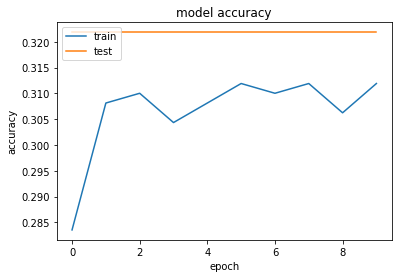

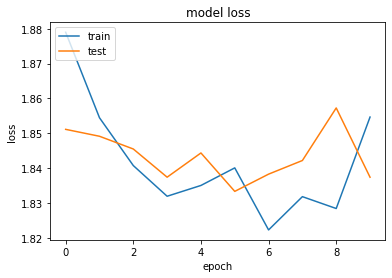

16/16 [==============================] - 6s 375ms/step
Test evaluation:
16/16 [==============================] - 6s 389ms/step - loss: 1.8854 - accuracy: 0.3052
[1.8854320049285889, 0.30519479513168335]
% of correct brand in the first 3 positions:
87
0.564935064935065
% of brand predicted with percentage >= 0.25
0.3051948051948052
% of brand predicted with percentage >= 0.5
0.0
% of brand predicted with percentage >= 0.75
0.0
Matriz de confusión:


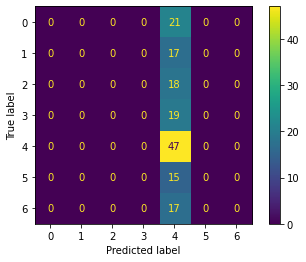

In [177]:
model_test01=executeModel(False, False, False, False, 10)

 
Training model with aumentation:True, gray:False, binary:False, crop:False and epochs = 10
Epoch 1/10
53/53 [==============================] - 61s 1s/step - loss: 10.9802 - accuracy: 0.3025 - val_loss: 9.5563 - val_accuracy: 0.3793
Epoch 2/10
53/53 [==============================] - 61s 1s/step - loss: 11.0602 - accuracy: 0.3138 - val_loss: 9.5880 - val_accuracy: 0.3793
Epoch 3/10
53/53 [==============================] - 60s 1s/step - loss: 11.0602 - accuracy: 0.3138 - val_loss: 9.5882 - val_accuracy: 0.3793
Epoch 4/10
53/53 [==============================] - 60s 1s/step - loss: 11.0602 - accuracy: 0.3138 - val_loss: 9.5891 - val_accuracy: 0.3793
Epoch 5/10
53/53 [==============================] - 60s 1s/step - loss: 11.0907 - accuracy: 0.3119 - val_loss: 9.5885 - val_accuracy: 0.3793
Epoch 6/10
53/53 [==============================] - 60s 1s/step - loss: 11.0602 - accuracy: 0.3138 - val_loss: 9.5885 - val_accuracy: 0.3793
Epoch 7/10
53/53 [==============================] - 60s 1s/st

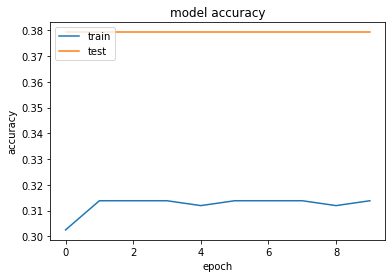

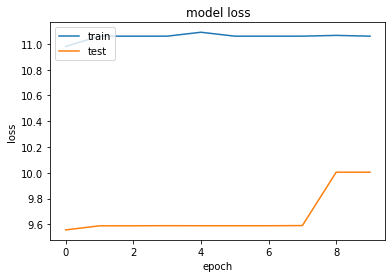

16/16 [==============================] - 4s 222ms/step
Test evaluation:
16/16 [==============================] - 4s 223ms/step - loss: 11.8269 - accuracy: 0.2662
[11.826915740966797, 0.26623377203941345]
% of correct brand in the first 3 positions:
89
0.577922077922078
% of brand predicted with percentage >= 0.25
0.2662337662337662
% of brand predicted with percentage >= 0.5
0.2662337662337662
% of brand predicted with percentage >= 0.75
0.2662337662337662
Matriz de confusión:


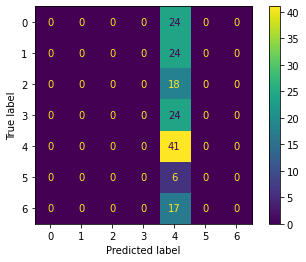

In [47]:
model_test02=executeModel(True, False, False, False, 10)

 
Training model with aumentation:False, gray:True, binary:False, crop:False and epochs = 10
Epoch 1/10
53/53 [==============================] - 76s 1s/step - loss: 1.8820 - accuracy: 0.2628 - val_loss: 1.8444 - val_accuracy: 0.3218
Epoch 2/10
53/53 [==============================] - 73s 1s/step - loss: 1.8461 - accuracy: 0.3119 - val_loss: 1.8407 - val_accuracy: 0.3218
Epoch 3/10
53/53 [==============================] - 75s 1s/step - loss: 1.8394 - accuracy: 0.3100 - val_loss: 1.8345 - val_accuracy: 0.3218
Epoch 4/10
53/53 [==============================] - 74s 1s/step - loss: 1.8400 - accuracy: 0.3006 - val_loss: 1.8364 - val_accuracy: 0.3218
Epoch 5/10
53/53 [==============================] - 75s 1s/step - loss: 1.8501 - accuracy: 0.2987 - val_loss: 1.8417 - val_accuracy: 0.3218
Epoch 6/10
53/53 [==============================] - 75s 1s/step - loss: 1.8395 - accuracy: 0.3062 - val_loss: 1.8362 - val_accuracy: 0.3218
Epoch 7/10
53/53 [==============================] - 73s 1s/step - l

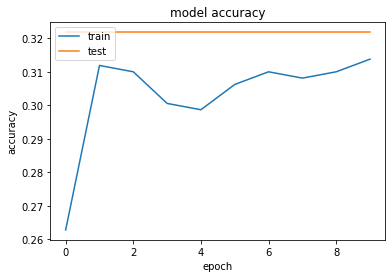

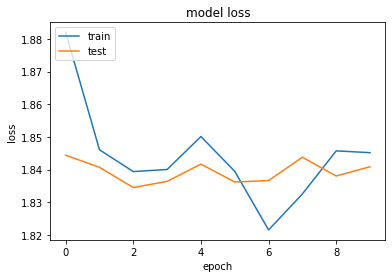

16/16 [==============================] - 5s 309ms/step
Test evaluation:
16/16 [==============================] - 5s 309ms/step - loss: 1.8762 - accuracy: 0.3052
[1.8761883974075317, 0.30519479513168335]
% of correct brand in the first 3 positions:
87
0.564935064935065
% of brand predicted with percentage >= 0.25
0.3051948051948052
% of brand predicted with percentage >= 0.5
0.0
% of brand predicted with percentage >= 0.75
0.0
Matriz de confusión:


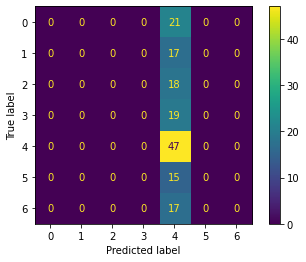

In [179]:
model_test03=executeModel(False, True, False, False, 10)

 
Training model with aumentation:False, gray:True, binary:True, crop:False and epochs = 10
Epoch 1/10
53/53 [==============================] - 62s 1s/step - loss: 2.3828 - accuracy: 0.2628 - val_loss: 1.7450 - val_accuracy: 0.3218
Epoch 2/10
53/53 [==============================] - 59s 1s/step - loss: 1.6245 - accuracy: 0.3762 - val_loss: 1.6468 - val_accuracy: 0.3678
Epoch 3/10
53/53 [==============================] - 60s 1s/step - loss: 1.2421 - accuracy: 0.5274 - val_loss: 1.4411 - val_accuracy: 0.4713
Epoch 4/10
53/53 [==============================] - 81s 2s/step - loss: 0.9045 - accuracy: 0.6730 - val_loss: 1.3460 - val_accuracy: 0.5517
Epoch 5/10
53/53 [==============================] - 85s 2s/step - loss: 0.5910 - accuracy: 0.7675 - val_loss: 1.5350 - val_accuracy: 0.5057
Epoch 6/10
53/53 [==============================] - 77s 1s/step - loss: 0.5069 - accuracy: 0.8336 - val_loss: 1.8639 - val_accuracy: 0.4713
Epoch 7/10
53/53 [==============================] - 77s 1s/step - lo

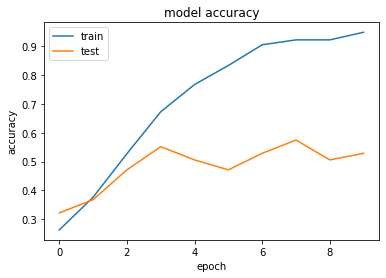

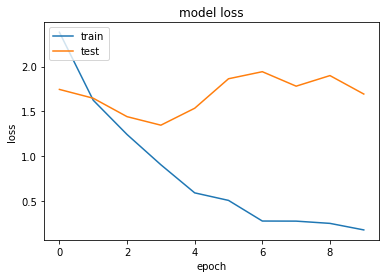

16/16 [==============================] - 5s 301ms/step
Test evaluation:
16/16 [==============================] - 5s 303ms/step - loss: 1.4311 - accuracy: 0.6104
[1.4310550689697266, 0.6103895902633667]
% of correct brand in the first 3 positions:
130
0.8441558441558441
% of brand predicted with percentage >= 0.25
0.12337662337662338
% of brand predicted with percentage >= 0.5
0.12337662337662338
% of brand predicted with percentage >= 0.75
0.12337662337662338
Matriz de confusión:


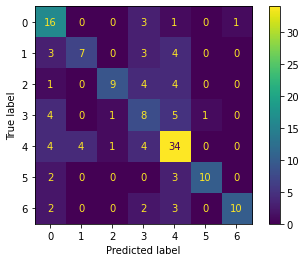

In [187]:
model_test04=executeModel(False, True, True, False, 10)

 
Training model with aumentation:True, gray:True, binary:False, crop:False and epochs = 10
Epoch 1/10
53/53 [==============================] - 57s 1s/step - loss: 2.8948 - accuracy: 0.2911 - val_loss: 1.9839 - val_accuracy: 0.3793
Epoch 2/10
53/53 [==============================] - 54s 1s/step - loss: 1.6720 - accuracy: 0.3176 - val_loss: 3.4131 - val_accuracy: 0.3793
Epoch 3/10
53/53 [==============================] - 54s 1s/step - loss: 1.5822 - accuracy: 0.3573 - val_loss: 2.4062 - val_accuracy: 0.3793
Epoch 4/10
53/53 [==============================] - 54s 1s/step - loss: 1.4783 - accuracy: 0.4480 - val_loss: 2.1607 - val_accuracy: 0.3793
Epoch 5/10
53/53 [==============================] - 54s 1s/step - loss: 1.3163 - accuracy: 0.5142 - val_loss: 2.3105 - val_accuracy: 0.0690
Epoch 6/10
53/53 [==============================] - 55s 1s/step - loss: 1.2099 - accuracy: 0.5595 - val_loss: 2.9211 - val_accuracy: 0.0690
Epoch 7/10
53/53 [==============================] - 54s 1s/step - lo

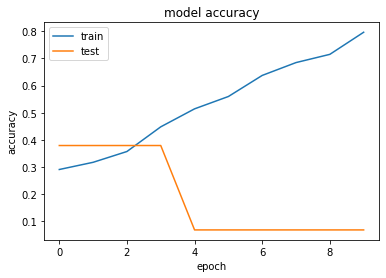

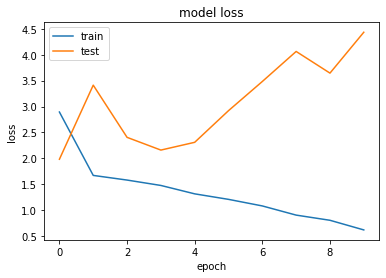

16/16 [==============================] - 3s 191ms/step
Test evaluation:
16/16 [==============================] - 3s 185ms/step - loss: 4.1703 - accuracy: 0.1558
[4.170345783233643, 0.15584415197372437]
% of correct brand in the first 3 positions:
72
0.4675324675324675
% of brand predicted with percentage >= 0.25
0.3116883116883117
% of brand predicted with percentage >= 0.5
0.15584415584415584
% of brand predicted with percentage >= 0.75
0.0
Matriz de confusión:


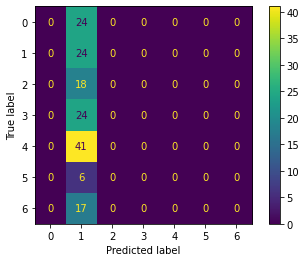

In [48]:
model_test05=executeModel(True, True, False, False, 10)

 
Training model with aumentation:False, gray:True, binary:True, crop:True and epochs = 10
Epoch 1/10
53/53 [==============================] - 83s 2s/step - loss: 2.3565 - accuracy: 0.2798 - val_loss: 1.7333 - val_accuracy: 0.3218
Epoch 2/10
53/53 [==============================] - 78s 1s/step - loss: 1.4362 - accuracy: 0.4575 - val_loss: 1.3203 - val_accuracy: 0.5287
Epoch 3/10
53/53 [==============================] - 78s 1s/step - loss: 0.9025 - accuracy: 0.6654 - val_loss: 1.0504 - val_accuracy: 0.6897
Epoch 4/10
53/53 [==============================] - 79s 1s/step - loss: 0.6889 - accuracy: 0.7637 - val_loss: 1.0032 - val_accuracy: 0.6782
Epoch 5/10
53/53 [==============================] - 79s 1s/step - loss: 0.4395 - accuracy: 0.8526 - val_loss: 1.1328 - val_accuracy: 0.6092
Epoch 6/10
53/53 [==============================] - 79s 1s/step - loss: 0.3727 - accuracy: 0.9055 - val_loss: 1.0501 - val_accuracy: 0.6322
Epoch 7/10
53/53 [==============================] - 78s 1s/step - los

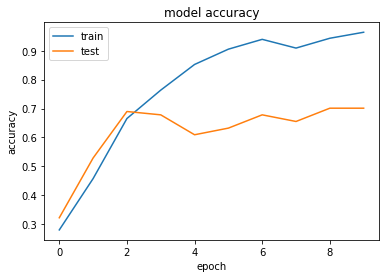

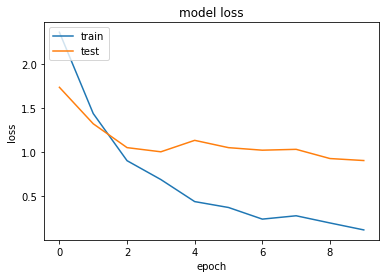

16/16 [==============================] - 6s 349ms/step
Test evaluation:
16/16 [==============================] - 6s 375ms/step - loss: 0.7334 - accuracy: 0.7987
[0.7333762645721436, 0.798701286315918]
% of correct brand in the first 3 positions:
145
0.9415584415584416
% of brand predicted with percentage >= 0.25
0.11688311688311688
% of brand predicted with percentage >= 0.5
0.11688311688311688
% of brand predicted with percentage >= 0.75
0.11688311688311688
Matriz de confusión:


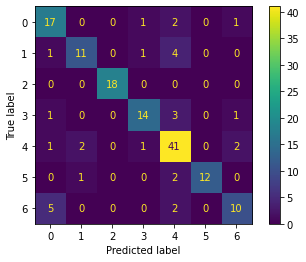

In [188]:
model_test06=executeModel(False, True, True, True, 10)

In [ ]:
modeltest06.summary()

 
Training model with aumentation:True, gray:True, binary:True, crop:True and epochs = 10
Epoch 1/10
53/53 [==============================] - 58s 1s/step - loss: 13.4060 - accuracy: 0.1531 - val_loss: 13.7096 - val_accuracy: 0.1494
Epoch 2/10
53/53 [==============================] - 55s 1s/step - loss: 13.5892 - accuracy: 0.1569 - val_loss: 13.7096 - val_accuracy: 0.1494
Epoch 3/10
53/53 [==============================] - 55s 1s/step - loss: 13.5892 - accuracy: 0.1569 - val_loss: 13.7096 - val_accuracy: 0.1494
Epoch 4/10
53/53 [==============================] - 55s 1s/step - loss: 13.5892 - accuracy: 0.1569 - val_loss: 13.7096 - val_accuracy: 0.1494
Epoch 5/10
53/53 [==============================] - 55s 1s/step - loss: 13.5892 - accuracy: 0.1569 - val_loss: 13.7096 - val_accuracy: 0.1494
Epoch 6/10
53/53 [==============================] - 55s 1s/step - loss: 13.5892 - accuracy: 0.1569 - val_loss: 13.7096 - val_accuracy: 0.1494
Epoch 7/10
53/53 [==============================] - 56s 1s

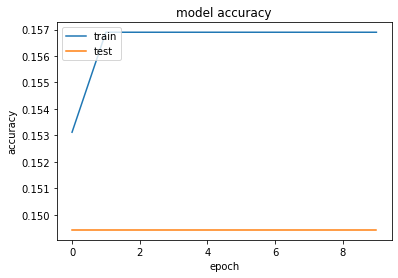

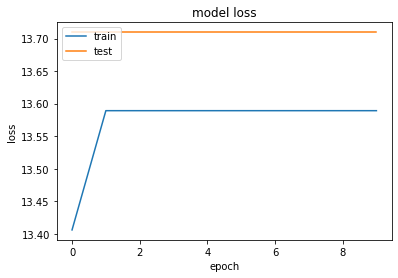

16/16 [==============================] - 4s 207ms/step
Test evaluation:
16/16 [==============================] - 3s 206ms/step - loss: 13.6062 - accuracy: 0.1558
[13.606184959411621, 0.15584415197372437]
% of correct brand in the first 3 positions:
72
0.4675324675324675
% of brand predicted with percentage >= 0.25
0.15584415584415584
% of brand predicted with percentage >= 0.5
0.15584415584415584
% of brand predicted with percentage >= 0.75
0.15584415584415584
Matriz de confusión:


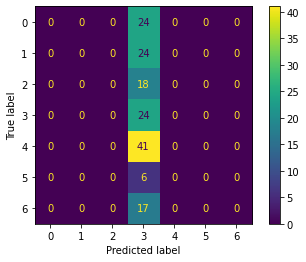

In [49]:
model_test07=executeModel(True, True, True, True, 10)

 
Training model with aumentation:False, gray:False, binary:False, crop:False and epochs = 25
Epoch 1/25
53/53 [==============================] - 66s 1s/step - loss: 1.8883 - accuracy: 0.2628 - val_loss: 1.8797 - val_accuracy: 0.1494
Epoch 2/25
53/53 [==============================] - 64s 1s/step - loss: 1.8627 - accuracy: 0.2968 - val_loss: 1.8455 - val_accuracy: 0.3218
Epoch 3/25
53/53 [==============================] - 64s 1s/step - loss: 1.8441 - accuracy: 0.2817 - val_loss: 1.8457 - val_accuracy: 0.3218
Epoch 4/25
53/53 [==============================] - 86s 2s/step - loss: 1.8601 - accuracy: 0.3043 - val_loss: 1.8323 - val_accuracy: 0.3218
Epoch 5/25
53/53 [==============================] - 86s 2s/step - loss: 1.8438 - accuracy: 0.3062 - val_loss: 1.8327 - val_accuracy: 0.3218
Epoch 6/25
53/53 [==============================] - 84s 2s/step - loss: 1.8446 - accuracy: 0.3100 - val_loss: 1.8341 - val_accuracy: 0.3218
Epoch 7/25
53/53 [==============================] - 86s 2s/step - 

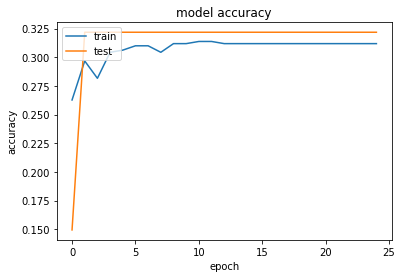

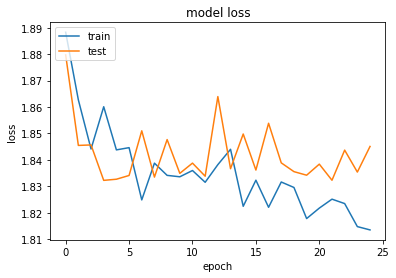

16/16 [==============================] - 7s 388ms/step
Test evaluation:
16/16 [==============================] - 6s 375ms/step - loss: 1.9063 - accuracy: 0.3052
[1.9063286781311035, 0.30519479513168335]
% of correct brand in the first 3 positions:
87
0.564935064935065
% of brand predicted with percentage >= 0.25
0.3051948051948052
% of brand predicted with percentage >= 0.5
0.0
% of brand predicted with percentage >= 0.75
0.0
Matriz de confusión:


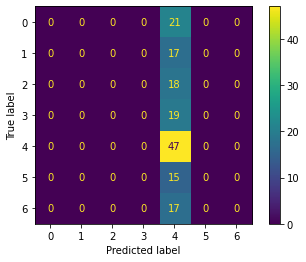

In [191]:
model_test08=executeModel(False, False, False, False, 25)

 
Training model with aumentation:True, gray:False, binary:False, crop:False and epochs = 25
Epoch 1/25
53/53 [==============================] - 60s 1s/step - loss: 3.1171 - accuracy: 0.2457 - val_loss: 1.8418 - val_accuracy: 0.3793
Epoch 2/25
53/53 [==============================] - 59s 1s/step - loss: 1.8412 - accuracy: 0.3025 - val_loss: 3.4349 - val_accuracy: 0.3793
Epoch 3/25
53/53 [==============================] - 58s 1s/step - loss: 1.6956 - accuracy: 0.3195 - val_loss: 3.7137 - val_accuracy: 0.3793
Epoch 4/25
53/53 [==============================] - 59s 1s/step - loss: 1.6118 - accuracy: 0.3629 - val_loss: 1.8591 - val_accuracy: 0.3793
Epoch 5/25
53/53 [==============================] - 58s 1s/step - loss: 1.5133 - accuracy: 0.4121 - val_loss: 1.8674 - val_accuracy: 0.3793
Epoch 6/25
53/53 [==============================] - 59s 1s/step - loss: 1.3334 - accuracy: 0.5047 - val_loss: 1.8905 - val_accuracy: 0.1494
Epoch 7/25
53/53 [==============================] - 59s 1s/step - l

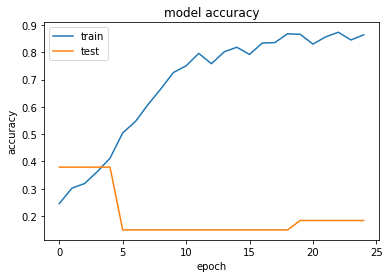

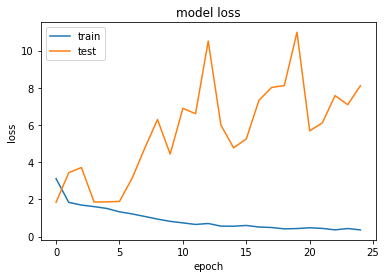

16/16 [==============================] - 4s 218ms/step
Test evaluation:
16/16 [==============================] - 4s 221ms/step - loss: 9.5877 - accuracy: 0.1558
[9.587703704833984, 0.15584415197372437]
% of correct brand in the first 3 positions:
89
0.577922077922078
% of brand predicted with percentage >= 0.25
0.15584415584415584
% of brand predicted with percentage >= 0.5
0.15584415584415584
% of brand predicted with percentage >= 0.75
0.15584415584415584
Matriz de confusión:


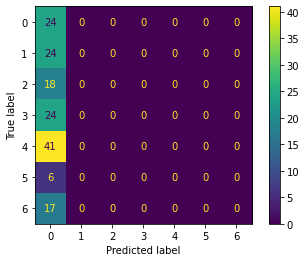

In [50]:
model_test09=executeModel(True, False, False, False, 25)

 
Training model with aumentation:False, gray:True, binary:False, crop:False and epochs = 25
Epoch 1/25
53/53 [==============================] - 85s 2s/step - loss: 1.8914 - accuracy: 0.2817 - val_loss: 1.8674 - val_accuracy: 0.3218
Epoch 2/25
53/53 [==============================] - 78s 1s/step - loss: 1.8511 - accuracy: 0.3119 - val_loss: 1.8421 - val_accuracy: 0.3218
Epoch 3/25
53/53 [==============================] - 78s 1s/step - loss: 1.8262 - accuracy: 0.3138 - val_loss: 1.8368 - val_accuracy: 0.3218
Epoch 4/25
53/53 [==============================] - 88s 2s/step - loss: 1.8388 - accuracy: 0.3119 - val_loss: 1.8383 - val_accuracy: 0.3218
Epoch 5/25
53/53 [==============================] - 87s 2s/step - loss: 1.8437 - accuracy: 0.3119 - val_loss: 1.8447 - val_accuracy: 0.3218
Epoch 6/25
53/53 [==============================] - 145s 3s/step - loss: 1.8313 - accuracy: 0.3119 - val_loss: 1.8515 - val_accuracy: 0.3218
Epoch 7/25
53/53 [==============================] - 94s 2s/step - 

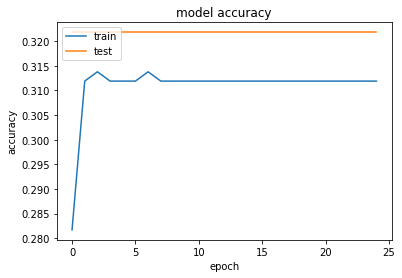

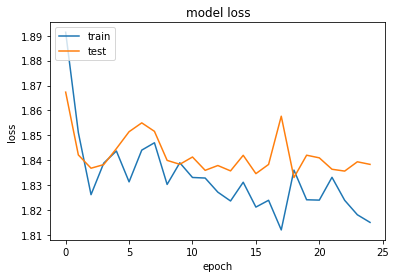

16/16 [==============================] - 8s 474ms/step
Test evaluation:
16/16 [==============================] - 8s 495ms/step - loss: 1.8908 - accuracy: 0.3052
[1.890782356262207, 0.30519479513168335]
% of correct brand in the first 3 positions:
87
0.564935064935065
% of brand predicted with percentage >= 0.25
0.3051948051948052
% of brand predicted with percentage >= 0.5
0.0
% of brand predicted with percentage >= 0.75
0.0
Matriz de confusión:


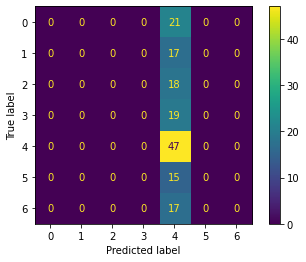

In [193]:
model_test10=executeModel(False, True, False, False, 25)

 
Training model with aumentation:False, gray:True, binary:True, crop:False and epochs = 25
Epoch 1/25
53/53 [==============================] - 101s 2s/step - loss: 5.6726 - accuracy: 0.2231 - val_loss: 1.8762 - val_accuracy: 0.3218
Epoch 2/25
53/53 [==============================] - 111s 2s/step - loss: 1.7330 - accuracy: 0.2930 - val_loss: 1.6575 - val_accuracy: 0.4138
Epoch 3/25
53/53 [==============================] - 119s 2s/step - loss: 1.2875 - accuracy: 0.5312 - val_loss: 1.4377 - val_accuracy: 0.4943
Epoch 4/25
53/53 [==============================] - 113s 2s/step - loss: 0.9249 - accuracy: 0.6975 - val_loss: 1.7630 - val_accuracy: 0.4598
Epoch 5/25
53/53 [==============================] - 110s 2s/step - loss: 0.5548 - accuracy: 0.8034 - val_loss: 1.3991 - val_accuracy: 0.4943
Epoch 6/25
53/53 [==============================] - 103s 2s/step - loss: 0.3255 - accuracy: 0.8790 - val_loss: 1.7523 - val_accuracy: 0.5287
Epoch 7/25
53/53 [==============================] - 106s 2s/st

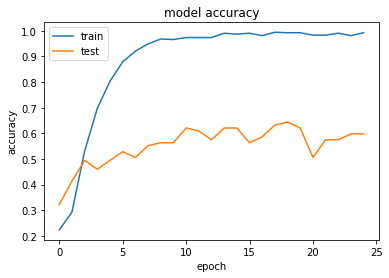

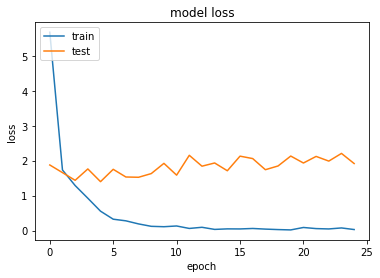

16/16 [==============================] - 5s 306ms/step
Test evaluation:
16/16 [==============================] - 5s 311ms/step - loss: 1.7246 - accuracy: 0.6688
[1.7245663404464722, 0.6688311696052551]
% of correct brand in the first 3 positions:
139
0.9025974025974026
% of brand predicted with percentage >= 0.25
0.12337662337662338
% of brand predicted with percentage >= 0.5
0.12337662337662338
% of brand predicted with percentage >= 0.75
0.12337662337662338
Matriz de confusión:


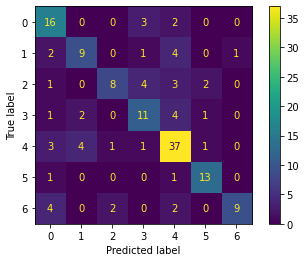

In [194]:
model_test11=executeModel(False, True, True, False, 25)

 
Training model with aumentation:True, gray:True, binary:False, crop:False and epochs = 25
Epoch 1/25
53/53 [==============================] - 56s 1s/step - loss: 2.4070 - accuracy: 0.2949 - val_loss: 1.7542 - val_accuracy: 0.3793
Epoch 2/25
53/53 [==============================] - 55s 1s/step - loss: 1.6752 - accuracy: 0.3573 - val_loss: 1.8065 - val_accuracy: 0.3793
Epoch 3/25
53/53 [==============================] - 55s 1s/step - loss: 1.5709 - accuracy: 0.4178 - val_loss: 1.8127 - val_accuracy: 0.3793
Epoch 4/25
53/53 [==============================] - 54s 1s/step - loss: 1.3428 - accuracy: 0.5009 - val_loss: 1.9631 - val_accuracy: 0.1494
Epoch 5/25
53/53 [==============================] - 54s 1s/step - loss: 1.2070 - accuracy: 0.5784 - val_loss: 2.2761 - val_accuracy: 0.1494
Epoch 6/25
53/53 [==============================] - 55s 1s/step - loss: 1.0199 - accuracy: 0.6333 - val_loss: 3.0260 - val_accuracy: 0.0690
Epoch 7/25
53/53 [==============================] - 55s 1s/step - lo

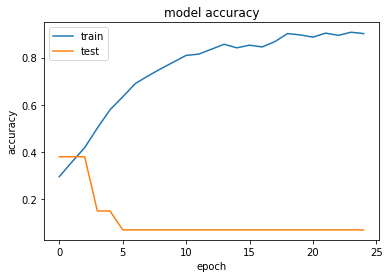

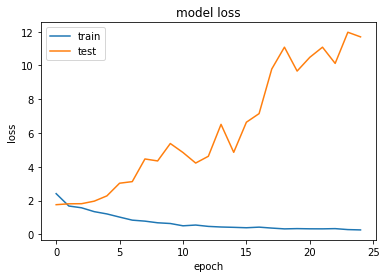

16/16 [==============================] - 3s 185ms/step
Test evaluation:
16/16 [==============================] - 3s 183ms/step - loss: 11.0019 - accuracy: 0.1558
[11.001900672912598, 0.15584415197372437]
% of correct brand in the first 3 positions:
89
0.577922077922078
% of brand predicted with percentage >= 0.25
0.15584415584415584
% of brand predicted with percentage >= 0.5
0.15584415584415584
% of brand predicted with percentage >= 0.75
0.15584415584415584
Matriz de confusión:


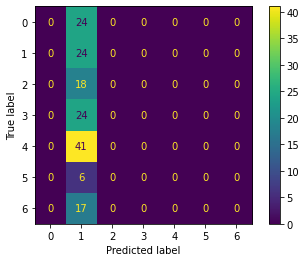

In [51]:
model_test12=executeModel(True, True, False, False, 25)

 
Training model with aumentation:False, gray:True, binary:True, crop:True and epochs = 25
Epoch 1/25
53/53 [==============================] - 61s 1s/step - loss: 4.6450 - accuracy: 0.2722 - val_loss: 1.7720 - val_accuracy: 0.3678
Epoch 2/25
53/53 [==============================] - 58s 1s/step - loss: 1.4696 - accuracy: 0.4688 - val_loss: 1.3985 - val_accuracy: 0.4943
Epoch 3/25
53/53 [==============================] - 58s 1s/step - loss: 0.8842 - accuracy: 0.6767 - val_loss: 1.1727 - val_accuracy: 0.5402
Epoch 4/25
53/53 [==============================] - 58s 1s/step - loss: 0.5761 - accuracy: 0.8015 - val_loss: 1.1511 - val_accuracy: 0.6667
Epoch 5/25
53/53 [==============================] - 57s 1s/step - loss: 0.4494 - accuracy: 0.8677 - val_loss: 0.9026 - val_accuracy: 0.7126
Epoch 6/25
53/53 [==============================] - 58s 1s/step - loss: 0.3347 - accuracy: 0.8979 - val_loss: 0.9449 - val_accuracy: 0.7931
Epoch 7/25
53/53 [==============================] - 58s 1s/step - los

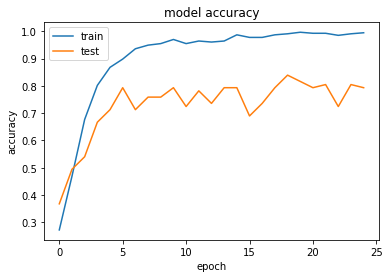

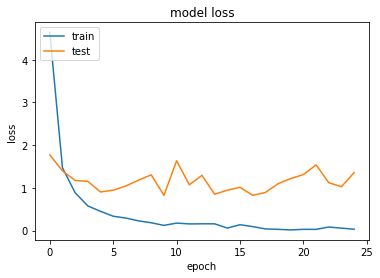

16/16 [==============================] - 4s 265ms/step
Test evaluation:
16/16 [==============================] - 5s 276ms/step - loss: 1.1137 - accuracy: 0.7727
[1.1136705875396729, 0.7727272510528564]
% of correct brand in the first 3 positions:
148
0.961038961038961
% of brand predicted with percentage >= 0.25
0.11688311688311688
% of brand predicted with percentage >= 0.5
0.11688311688311688
% of brand predicted with percentage >= 0.75
0.11688311688311688
Matriz de confusión:


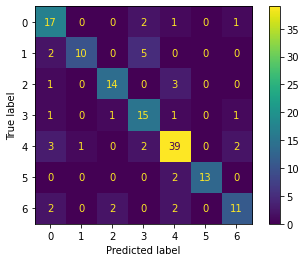

In [196]:
model_test13=executeModel(False, True, True, True, 25)

 
Training model with aumentation:True, gray:True, binary:True, crop:True and epochs = 25
Epoch 1/25
53/53 [==============================] - 57s 1s/step - loss: 10.5305 - accuracy: 0.1871 - val_loss: 2.0613 - val_accuracy: 0.3793
Epoch 2/25
53/53 [==============================] - 57s 1s/step - loss: 7.3262 - accuracy: 0.2495 - val_loss: 4.5063 - val_accuracy: 0.3793
Epoch 3/25
53/53 [==============================] - 58s 1s/step - loss: 7.5270 - accuracy: 0.2703 - val_loss: 2.1345 - val_accuracy: 0.2299
Epoch 4/25
53/53 [==============================] - 57s 1s/step - loss: 7.5129 - accuracy: 0.2155 - val_loss: 1.7536 - val_accuracy: 0.3793
Epoch 5/25
53/53 [==============================] - 56s 1s/step - loss: 6.4443 - accuracy: 0.3138 - val_loss: 1.6408 - val_accuracy: 0.3793
Epoch 6/25
53/53 [==============================] - 57s 1s/step - loss: 6.2977 - accuracy: 0.3081 - val_loss: 1.5909 - val_accuracy: 0.3908
Epoch 7/25
53/53 [==============================] - 57s 1s/step - los

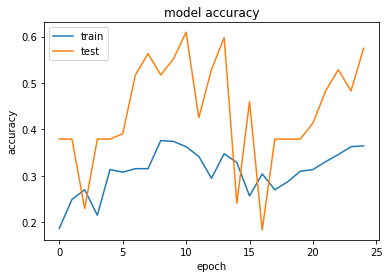

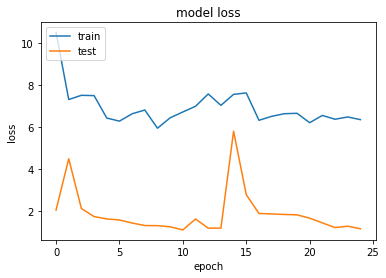

16/16 [==============================] - 4s 227ms/step
Test evaluation:
16/16 [==============================] - 4s 243ms/step - loss: 1.4073 - accuracy: 0.4351
[1.4072834253311157, 0.4350649416446686]
% of correct brand in the first 3 positions:
123
0.7987012987012987
% of brand predicted with percentage >= 0.25
0.42207792207792205
% of brand predicted with percentage >= 0.5
0.0
% of brand predicted with percentage >= 0.75
0.0
Matriz de confusión:


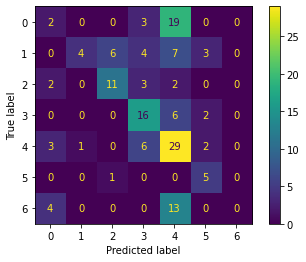

In [52]:
model_test14=executeModel(True, True, True, True, 25) 

 
Training model with aumentation:False, gray:False, binary:False, crop:False and epochs = 5
Epoch 1/5
53/53 [==============================] - 102s 2s/step - loss: 1.8936 - accuracy: 0.2817 - val_loss: 1.8616 - val_accuracy: 0.3218
Epoch 2/5
53/53 [==============================] - 93s 2s/step - loss: 1.8299 - accuracy: 0.3195 - val_loss: 1.8369 - val_accuracy: 0.3218
Epoch 3/5
53/53 [==============================] - 67s 1s/step - loss: 1.8460 - accuracy: 0.3043 - val_loss: 1.8542 - val_accuracy: 0.3218
Epoch 4/5
53/53 [==============================] - 65s 1s/step - loss: 1.8527 - accuracy: 0.3025 - val_loss: 1.8415 - val_accuracy: 0.3218
Epoch 5/5
53/53 [==============================] - 61s 1s/step - loss: 1.8450 - accuracy: 0.3214 - val_loss: 1.8320 - val_accuracy: 0.3218


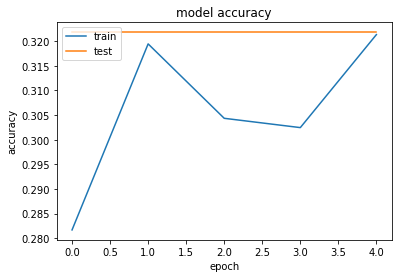

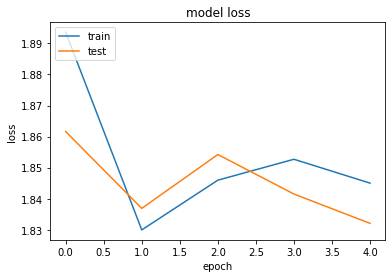

16/16 [==============================] - 5s 266ms/step
Test evaluation:
16/16 [==============================] - 5s 274ms/step - loss: 1.8756 - accuracy: 0.3052
[1.8755677938461304, 0.30519479513168335]
% of correct brand in the first 3 positions:
87
0.564935064935065
% of brand predicted with percentage >= 0.25
0.3051948051948052
% of brand predicted with percentage >= 0.5
0.0
% of brand predicted with percentage >= 0.75
0.0
Matriz de confusión:


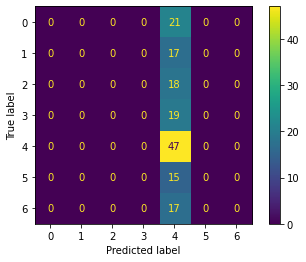

In [198]:
model_test15=executeModel(False, False, False, False, 5)

 
Training model with aumentation:True, gray:False, binary:False, crop:False and epochs = 5
Epoch 1/5
53/53 [==============================] - 63s 1s/step - loss: 3.2550 - accuracy: 0.2798 - val_loss: 1.7631 - val_accuracy: 0.3793
Epoch 2/5
53/53 [==============================] - 61s 1s/step - loss: 1.6693 - accuracy: 0.3176 - val_loss: 1.7804 - val_accuracy: 0.3793
Epoch 3/5
53/53 [==============================] - 62s 1s/step - loss: 1.5428 - accuracy: 0.4121 - val_loss: 1.9362 - val_accuracy: 0.1494
Epoch 4/5
53/53 [==============================] - 72s 1s/step - loss: 1.3993 - accuracy: 0.4877 - val_loss: 1.9280 - val_accuracy: 0.1494
Epoch 5/5
53/53 [==============================] - 92s 2s/step - loss: 1.3414 - accuracy: 0.5047 - val_loss: 1.9478 - val_accuracy: 0.0920


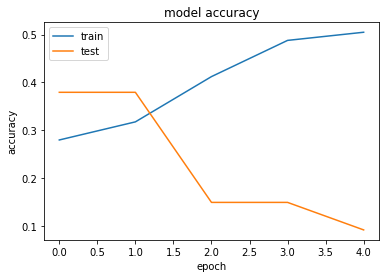

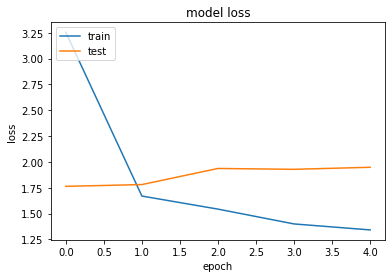

16/16 [==============================] - 11s 678ms/step
Test evaluation:
16/16 [==============================] - 14s 828ms/step - loss: 1.9566 - accuracy: 0.0390
[1.9566270112991333, 0.03896103799343109]
% of correct brand in the first 3 positions:
48
0.3116883116883117
% of brand predicted with percentage >= 0.25
0.0
% of brand predicted with percentage >= 0.5
0.0
% of brand predicted with percentage >= 0.75
0.0
Matriz de confusión:


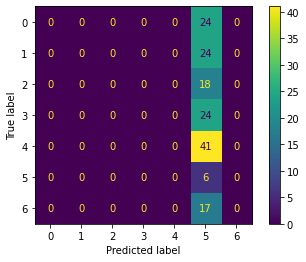

In [53]:
model_test16=executeModel(True, False, False, False, 5)

 
Training model with aumentation:False, gray:True, binary:True, crop:False and epochs = 5
Epoch 1/5
53/53 [==============================] - 64s 1s/step - loss: 2.3362 - accuracy: 0.2533 - val_loss: 1.8988 - val_accuracy: 0.3218
Epoch 2/5
53/53 [==============================] - 62s 1s/step - loss: 1.5657 - accuracy: 0.4216 - val_loss: 1.4903 - val_accuracy: 0.4368
Epoch 3/5
53/53 [==============================] - 62s 1s/step - loss: 1.1201 - accuracy: 0.5803 - val_loss: 1.4387 - val_accuracy: 0.4253
Epoch 4/5
53/53 [==============================] - 58s 1s/step - loss: 0.7186 - accuracy: 0.7353 - val_loss: 1.3458 - val_accuracy: 0.5632
Epoch 5/5
53/53 [==============================] - 58s 1s/step - loss: 0.4182 - accuracy: 0.8715 - val_loss: 1.3342 - val_accuracy: 0.5287


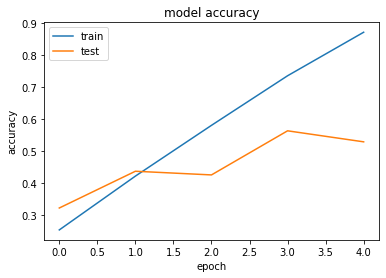

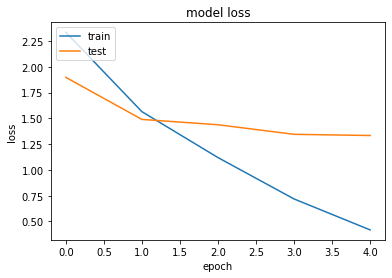

16/16 [==============================] - 4s 224ms/step
Test evaluation:
16/16 [==============================] - 4s 260ms/step - loss: 1.1404 - accuracy: 0.6364
[1.1404340267181396, 0.6363636255264282]
% of correct brand in the first 3 positions:
131
0.8506493506493507
% of brand predicted with percentage >= 0.25
0.12337662337662338
% of brand predicted with percentage >= 0.5
0.12337662337662338
% of brand predicted with percentage >= 0.75
0.12337662337662338
Matriz de confusión:


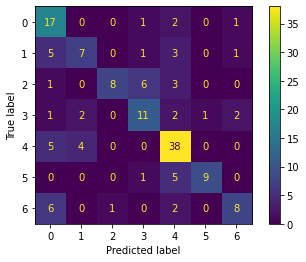

In [201]:
model_test17=executeModel(False, True, True, False, 5)

 
Training model with aumentation:False, gray:True, binary:True, crop:True and epochs = 5
Epoch 1/5
53/53 [==============================] - 60s 1s/step - loss: 3.3377 - accuracy: 0.2665 - val_loss: 1.7368 - val_accuracy: 0.3218
Epoch 2/5
53/53 [==============================] - 58s 1s/step - loss: 1.4831 - accuracy: 0.4197 - val_loss: 1.3622 - val_accuracy: 0.5632
Epoch 3/5
53/53 [==============================] - 58s 1s/step - loss: 1.0336 - accuracy: 0.6541 - val_loss: 1.0505 - val_accuracy: 0.6092
Epoch 4/5
53/53 [==============================] - 59s 1s/step - loss: 0.6150 - accuracy: 0.7826 - val_loss: 0.8344 - val_accuracy: 0.7241
Epoch 5/5
53/53 [==============================] - 59s 1s/step - loss: 0.4297 - accuracy: 0.8582 - val_loss: 1.0351 - val_accuracy: 0.6667


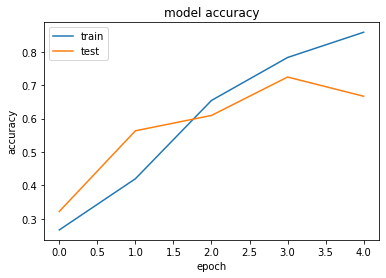

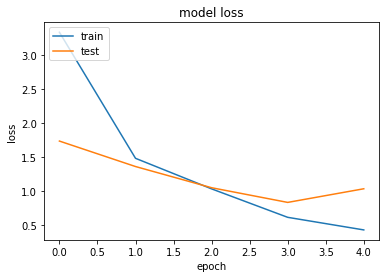

16/16 [==============================] - 4s 239ms/step
Test evaluation:
16/16 [==============================] - 4s 252ms/step - loss: 1.0697 - accuracy: 0.6883
[1.069715976715088, 0.6883116960525513]
% of correct brand in the first 3 positions:
141
0.9155844155844156
% of brand predicted with percentage >= 0.25
0.11688311688311688
% of brand predicted with percentage >= 0.5
0.11688311688311688
% of brand predicted with percentage >= 0.75
0.11688311688311688
Matriz de confusión:


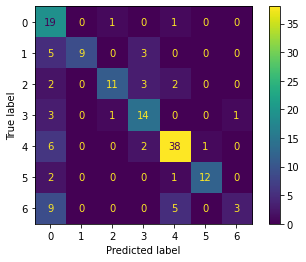

In [204]:
model_test18=executeModel(False, True, True, True, 5)

 
Training model with aumentation:True, gray:True, binary:True, crop:True and epochs = 5
Epoch 1/5
53/53 [==============================] - 95s 2s/step - loss: 8.6425 - accuracy: 0.2382 - val_loss: 2.1593 - val_accuracy: 0.3793
Epoch 2/5
53/53 [==============================] - 84s 2s/step - loss: 6.8847 - accuracy: 0.2268 - val_loss: 1.8063 - val_accuracy: 0.3793
Epoch 3/5
53/53 [==============================] - 90s 2s/step - loss: 6.4831 - accuracy: 0.2873 - val_loss: 1.7292 - val_accuracy: 0.3793
Epoch 4/5
53/53 [==============================] - 71s 1s/step - loss: 6.7045 - accuracy: 0.3025 - val_loss: 1.7658 - val_accuracy: 0.3793
Epoch 5/5
53/53 [==============================] - 68s 1s/step - loss: 6.2600 - accuracy: 0.3043 - val_loss: 1.5028 - val_accuracy: 0.4598


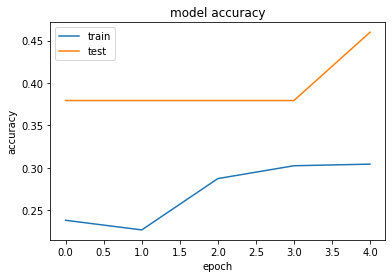

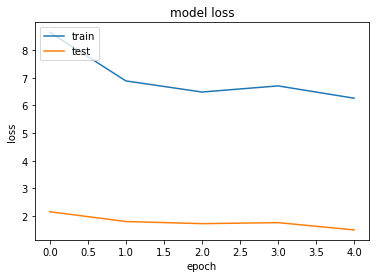

16/16 [==============================] - 5s 266ms/step
Test evaluation:
16/16 [==============================] - 5s 277ms/step - loss: 1.7120 - accuracy: 0.3052
[1.7119717597961426, 0.30519479513168335]
% of correct brand in the first 3 positions:
117
0.7597402597402597
% of brand predicted with percentage >= 0.25
0.2662337662337662
% of brand predicted with percentage >= 0.5
0.2662337662337662
% of brand predicted with percentage >= 0.75
0.0
Matriz de confusión:


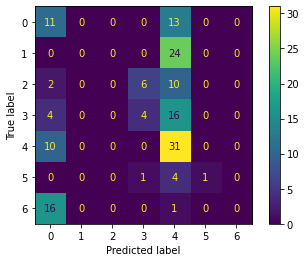

In [54]:
model_test19=executeModel(True, True, True, True, 5)

 
Training model with aumentation:False, gray:False, binary:False, crop:False and epochs = 50
Epoch 1/50
53/53 [==============================] - 60s 1s/step - loss: 1.8774 - accuracy: 0.2703 - val_loss: 1.8799 - val_accuracy: 0.3218
Epoch 2/50
53/53 [==============================] - 55s 1s/step - loss: 1.8674 - accuracy: 0.3006 - val_loss: 1.8411 - val_accuracy: 0.3218
Epoch 3/50
53/53 [==============================] - 54s 1s/step - loss: 1.8305 - accuracy: 0.3119 - val_loss: 1.8402 - val_accuracy: 0.3218
Epoch 4/50
53/53 [==============================] - 60s 1s/step - loss: 1.8238 - accuracy: 0.3138 - val_loss: 1.8383 - val_accuracy: 0.3218
Epoch 5/50
53/53 [==============================] - 65s 1s/step - loss: 1.8401 - accuracy: 0.3062 - val_loss: 1.8354 - val_accuracy: 0.3218
Epoch 6/50
53/53 [==============================] - 62s 1s/step - loss: 1.8352 - accuracy: 0.3081 - val_loss: 1.8363 - val_accuracy: 0.3218
Epoch 7/50
53/53 [==============================] - 62s 1s/step - 

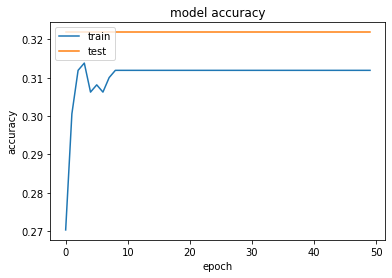

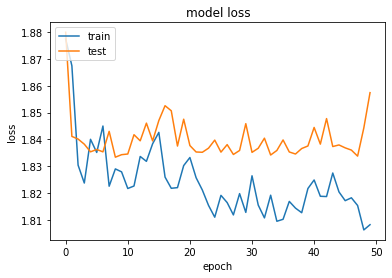

16/16 [==============================] - 5s 272ms/step
Test evaluation:
16/16 [==============================] - 5s 330ms/step - loss: 1.9241 - accuracy: 0.3052
[1.9240790605545044, 0.30519479513168335]
% of correct brand in the first 3 positions:
87
0.564935064935065
% of brand predicted with percentage >= 0.25
0.3051948051948052
% of brand predicted with percentage >= 0.5
0.0
% of brand predicted with percentage >= 0.75
0.0
Matriz de confusión:


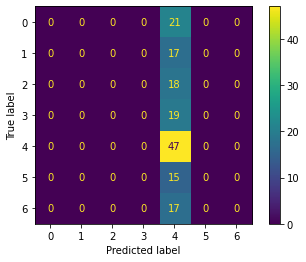

In [206]:
model_test20=executeModel(False, False, False, False, 50)

 
Training model with aumentation:True, gray:False, binary:False, crop:False and epochs = 50
Epoch 1/50
53/53 [==============================] - 75s 1s/step - loss: 7.8539 - accuracy: 0.1701 - val_loss: 1.9095 - val_accuracy: 0.3793
Epoch 2/50
53/53 [==============================] - 74s 1s/step - loss: 1.8471 - accuracy: 0.3062 - val_loss: 1.7369 - val_accuracy: 0.3793
Epoch 3/50
53/53 [==============================] - 74s 1s/step - loss: 1.7899 - accuracy: 0.3081 - val_loss: 2.3456 - val_accuracy: 0.3793
Epoch 4/50
53/53 [==============================] - 73s 1s/step - loss: 1.6913 - accuracy: 0.3119 - val_loss: 2.3048 - val_accuracy: 0.3793
Epoch 5/50
53/53 [==============================] - 74s 1s/step - loss: 1.5661 - accuracy: 0.4234 - val_loss: 4.4014 - val_accuracy: 0.3793
Epoch 6/50
53/53 [==============================] - 73s 1s/step - loss: 1.4409 - accuracy: 0.4461 - val_loss: 6.1858 - val_accuracy: 0.3793
Epoch 7/50
53/53 [==============================] - 100s 2s/step - 

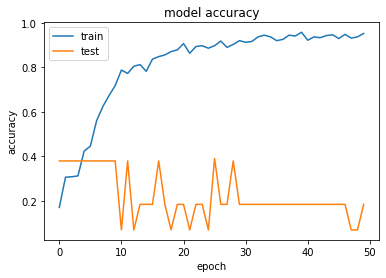

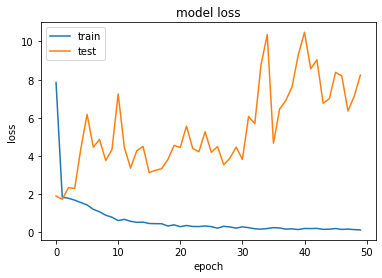

16/16 [==============================] - 5s 277ms/step
Test evaluation:
16/16 [==============================] - 5s 303ms/step - loss: 8.2145 - accuracy: 0.1558
[8.21447467803955, 0.15584415197372437]
% of correct brand in the first 3 positions:
89
0.577922077922078
% of brand predicted with percentage >= 0.25
0.3116883116883117
% of brand predicted with percentage >= 0.5
0.15584415584415584
% of brand predicted with percentage >= 0.75
0.0
Matriz de confusión:


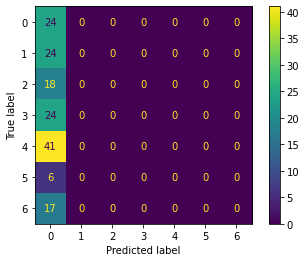

In [55]:
model_test21=executeModel(True, False, False, False, 50)

 
Training model with aumentation:False, gray:True, binary:True, crop:False and epochs = 50
Epoch 1/50
53/53 [==============================] - 57s 1s/step - loss: 3.0693 - accuracy: 0.2817 - val_loss: 1.6831 - val_accuracy: 0.3448
Epoch 2/50
53/53 [==============================] - 56s 1s/step - loss: 1.4522 - accuracy: 0.4612 - val_loss: 1.4167 - val_accuracy: 0.5057
Epoch 3/50
53/53 [==============================] - 56s 1s/step - loss: 1.0020 - accuracy: 0.6616 - val_loss: 1.4982 - val_accuracy: 0.4943
Epoch 4/50
53/53 [==============================] - 56s 1s/step - loss: 0.6571 - accuracy: 0.7599 - val_loss: 1.3249 - val_accuracy: 0.5172
Epoch 5/50
53/53 [==============================] - 55s 1s/step - loss: 0.4764 - accuracy: 0.8450 - val_loss: 1.5395 - val_accuracy: 0.5402
Epoch 6/50
53/53 [==============================] - 56s 1s/step - loss: 0.3444 - accuracy: 0.8922 - val_loss: 1.7589 - val_accuracy: 0.5402
Epoch 7/50
53/53 [==============================] - 56s 1s/step - lo

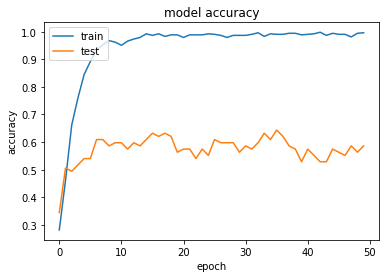

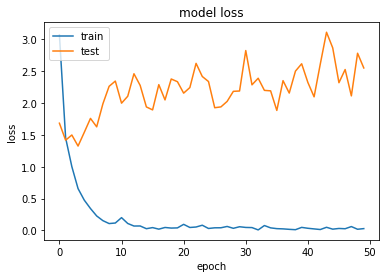

16/16 [==============================] - 3s 187ms/step
Test evaluation:
16/16 [==============================] - 3s 189ms/step - loss: 2.0034 - accuracy: 0.6558
[2.003368854522705, 0.6558441519737244]
% of correct brand in the first 3 positions:
139
0.9025974025974026
% of brand predicted with percentage >= 0.25
0.12337662337662338
% of brand predicted with percentage >= 0.5
0.12337662337662338
% of brand predicted with percentage >= 0.75
0.12337662337662338
Matriz de confusión:


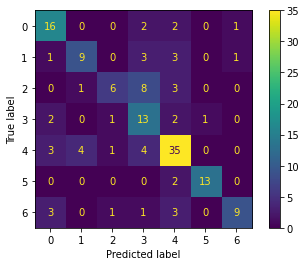

In [208]:
model_test22=executeModel(False, True, True, False, 50)

 
Training model with aumentation:False, gray:True, binary:True, crop:True and epochs = 50
Epoch 1/50
53/53 [==============================] - 59s 1s/step - loss: 2.5266 - accuracy: 0.3100 - val_loss: 1.6954 - val_accuracy: 0.4598
Epoch 2/50
53/53 [==============================] - 55s 1s/step - loss: 1.2797 - accuracy: 0.5444 - val_loss: 1.2705 - val_accuracy: 0.5517
Epoch 3/50
53/53 [==============================] - 54s 1s/step - loss: 0.8139 - accuracy: 0.7297 - val_loss: 1.0391 - val_accuracy: 0.5632
Epoch 4/50
53/53 [==============================] - 53s 1s/step - loss: 0.4748 - accuracy: 0.8677 - val_loss: 1.1015 - val_accuracy: 0.6207
Epoch 5/50
53/53 [==============================] - 53s 1s/step - loss: 0.2702 - accuracy: 0.9187 - val_loss: 1.1465 - val_accuracy: 0.6782
Epoch 6/50
53/53 [==============================] - 53s 991ms/step - loss: 0.2555 - accuracy: 0.9471 - val_loss: 1.2081 - val_accuracy: 0.7011
Epoch 7/50
53/53 [==============================] - 53s 995ms/step

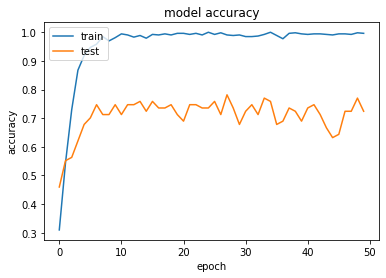

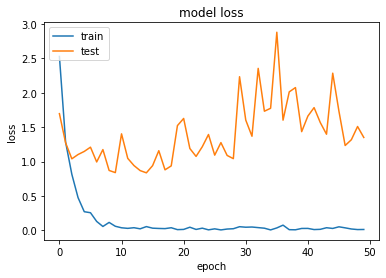

16/16 [==============================] - 5s 267ms/step
Test evaluation:
16/16 [==============================] - 5s 290ms/step - loss: 1.0314 - accuracy: 0.8117
[1.0313525199890137, 0.8116883039474487]
% of correct brand in the first 3 positions:
150
0.974025974025974
% of brand predicted with percentage >= 0.25
0.11688311688311688
% of brand predicted with percentage >= 0.5
0.11688311688311688
% of brand predicted with percentage >= 0.75
0.11688311688311688
Matriz de confusión:


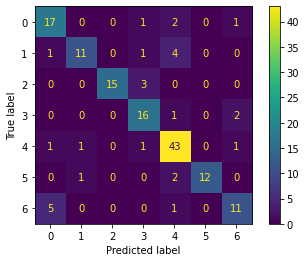

In [214]:
model_test23=executeModel(False, True, True, True, 50)

 
Training model with aumentation:True, gray:True, binary:True, crop:True and epochs = 50
Epoch 1/50
53/53 [==============================] - 69s 1s/step - loss: 7.3849 - accuracy: 0.2703 - val_loss: 1.7350 - val_accuracy: 0.3793
Epoch 2/50
53/53 [==============================] - 70s 1s/step - loss: 7.5945 - accuracy: 0.2136 - val_loss: 1.6944 - val_accuracy: 0.3793
Epoch 3/50
53/53 [==============================] - 68s 1s/step - loss: 8.2336 - accuracy: 0.2042 - val_loss: 1.6338 - val_accuracy: 0.3908
Epoch 4/50
53/53 [==============================] - 72s 1s/step - loss: 8.2129 - accuracy: 0.2193 - val_loss: 2.7541 - val_accuracy: 0.1494
Epoch 5/50
53/53 [==============================] - 69s 1s/step - loss: 8.0030 - accuracy: 0.2268 - val_loss: 1.6242 - val_accuracy: 0.4138
Epoch 6/50
53/53 [==============================] - 69s 1s/step - loss: 8.2437 - accuracy: 0.2363 - val_loss: 1.5424 - val_accuracy: 0.4598
Epoch 7/50
53/53 [==============================] - 67s 1s/step - loss

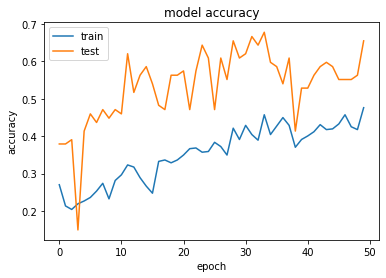

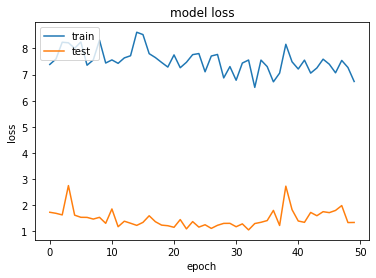

16/16 [==============================] - 4s 233ms/step
Test evaluation:
16/16 [==============================] - 4s 243ms/step - loss: 1.6034 - accuracy: 0.6039
[1.6033967733383179, 0.6038960814476013]
% of correct brand in the first 3 positions:
144
0.935064935064935
% of brand predicted with percentage >= 0.25
0.2662337662337662
% of brand predicted with percentage >= 0.5
0.2662337662337662
% of brand predicted with percentage >= 0.75
0.2662337662337662
Matriz de confusión:


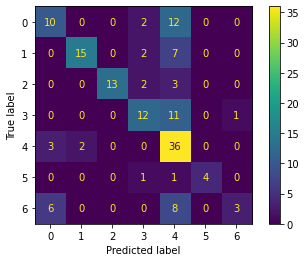

In [56]:
model_test24=executeModel(True,  True, True, True, 50)

### Experimentos con diferentes valores de muestras mínimas por marca



In [57]:

def returnDataByMinSample ( minSample, deleteNone=True):
    
    dfbrandMin, dfbrandoneMin = filterMinSamples(dfbrandall, minSample, deleteNone)
    num_classesMin=len(dfbrandMin)
    df_shoe_brandMin = filterBrands(df_shoe_brand_all,dfbrandoneMin, deleteNone)
    print(df_shoe_brandMin.shape)
    shoes_trainMin, shoes_testMin, shoes_valMin = split_datafiles(df_shoe_brandMin)

    while checkBalancedSample(shoes_trainMin, shoes_testMin, shoes_valMin) == False:
        shoes_trainMin, shoes_testMin, shoes_valMin = split_datafiles(df_shoe_brandMin)
    
    return num_classesMin, df_shoe_brandMin, shoes_trainMin, shoes_testMin, shoes_valMin

In [58]:
num_classes3, df_shoe_brand3,shoes_train3, shoes_test3, shoes_val3 = returnDataByMinSample(3)

             x   y
0       Adidas  12
6        Asics  13
12    Champion   3
15    Converse   7
30        Keen   3
33  Newbalance   4
34        Nike  24
42     Saucony   6
44     Shoopen   3
46    Skechers   8
50      Sperry   7
54        Teva   3
Brands with at least 3 samples: 12
Brands with only 1 register: 47
(930, 3)


 
Training model with aumentation:False, gray:False, binary:False, crop:False and epochs = 10
Epoch 1/10
64/64 [==============================] - 75s 1s/step - loss: 2.4030 - accuracy: 0.2191 - val_loss: 2.4143 - val_accuracy: 0.2190
Epoch 2/10
64/64 [==============================] - 108s 2s/step - loss: 2.3589 - accuracy: 0.2128 - val_loss: 2.3148 - val_accuracy: 0.2190
Epoch 3/10
64/64 [==============================] - 103s 2s/step - loss: 2.3192 - accuracy: 0.2316 - val_loss: 2.3290 - val_accuracy: 0.2190
Epoch 4/10
64/64 [==============================] - 106s 2s/step - loss: 2.3075 - accuracy: 0.2316 - val_loss: 2.3340 - val_accuracy: 0.2190
Epoch 5/10
64/64 [==============================] - 102s 2s/step - loss: 2.3032 - accuracy: 0.2285 - val_loss: 2.3366 - val_accuracy: 0.2190
Epoch 6/10
64/64 [==============================] - 98s 2s/step - loss: 2.3040 - accuracy: 0.2363 - val_loss: 2.3318 - val_accuracy: 0.2190
Epoch 7/10
64/64 [==============================] - 111s 2s/st

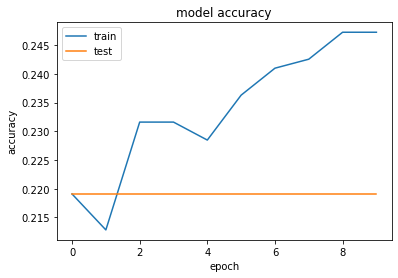

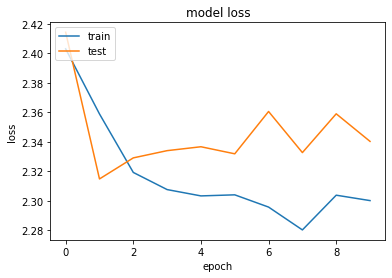

19/19 [==============================] - 7s 346ms/step
Test evaluation:
19/19 [==============================] - 7s 358ms/step - loss: 2.2619 - accuracy: 0.3226
[2.261904716491699, 0.32258063554763794]
% of correct brand in the first 3 positions:
102
0.5483870967741935
% of brand predicted with percentage >= 0.25
0.0
% of brand predicted with percentage >= 0.5
0.0
% of brand predicted with percentage >= 0.75
0.0
Matriz de confusión:


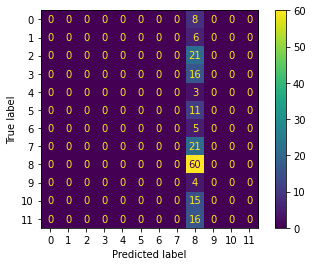

In [225]:
model_test25=executeModelData(False, False, False, False, 10, shoes_train3, shoes_test3, shoes_val3, df_shoe_brand3,num_classes3)

 
Training model with aumentation:True, gray:False, binary:False, crop:False and epochs = 10
Epoch 1/10
64/64 [==============================] - 78s 1s/step - loss: 3.6267 - accuracy: 0.2457 - val_loss: 2.4276 - val_accuracy: 0.2381
Epoch 2/10
64/64 [==============================] - 77s 1s/step - loss: 2.1708 - accuracy: 0.2739 - val_loss: 2.4399 - val_accuracy: 0.2381
Epoch 3/10
64/64 [==============================] - 77s 1s/step - loss: 2.0494 - accuracy: 0.3083 - val_loss: 2.7687 - val_accuracy: 0.2381
Epoch 4/10
64/64 [==============================] - 78s 1s/step - loss: 1.8782 - accuracy: 0.3678 - val_loss: 3.5619 - val_accuracy: 0.1143
Epoch 5/10
64/64 [==============================] - 78s 1s/step - loss: 1.7087 - accuracy: 0.4272 - val_loss: 4.1632 - val_accuracy: 0.1143
Epoch 6/10
64/64 [==============================] - 77s 1s/step - loss: 1.5154 - accuracy: 0.5102 - val_loss: 5.2166 - val_accuracy: 0.1143
Epoch 7/10
64/64 [==============================] - 77s 1s/step - l

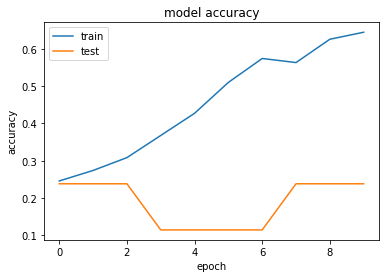

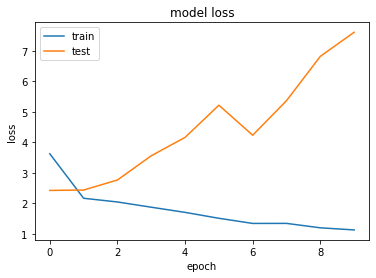

19/19 [==============================] - 5s 264ms/step
Test evaluation:
19/19 [==============================] - 5s 270ms/step - loss: 7.1554 - accuracy: 0.2204
[7.155381202697754, 0.22043010592460632]
% of correct brand in the first 3 positions:
94
0.5053763440860215
% of brand predicted with percentage >= 0.25
0.34408602150537637
% of brand predicted with percentage >= 0.5
0.22043010752688172
% of brand predicted with percentage >= 0.75
0.0
Matriz de confusión:


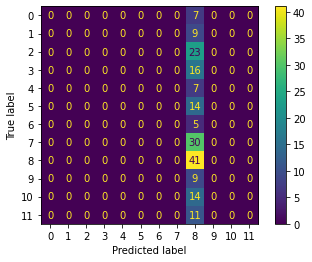

In [59]:
model_test26=executeModelData(True, False, False, False, 10, shoes_train3, shoes_test3, shoes_val3, df_shoe_brand3,num_classes3)

 
Training model with aumentation:False, gray:True, binary:True, crop:True and epochs = 10
Epoch 1/10
64/64 [==============================] - 149s 2s/step - loss: 14.6921 - accuracy: 0.0782 - val_loss: 14.8901 - val_accuracy: 0.0762
Epoch 2/10
64/64 [==============================] - 139s 2s/step - loss: 14.8065 - accuracy: 0.0814 - val_loss: 14.8901 - val_accuracy: 0.0762
Epoch 3/10
64/64 [==============================] - 135s 2s/step - loss: 14.8317 - accuracy: 0.0798 - val_loss: 14.8901 - val_accuracy: 0.0762
Epoch 4/10
64/64 [==============================] - 132s 2s/step - loss: 14.8317 - accuracy: 0.0798 - val_loss: 14.8901 - val_accuracy: 0.0762
Epoch 5/10
64/64 [==============================] - 70s 1s/step - loss: 14.8317 - accuracy: 0.0798 - val_loss: 14.8901 - val_accuracy: 0.0762
Epoch 6/10
64/64 [==============================] - 75s 1s/step - loss: 14.8317 - accuracy: 0.0798 - val_loss: 14.8901 - val_accuracy: 0.0762
Epoch 7/10
64/64 [==============================] - 7

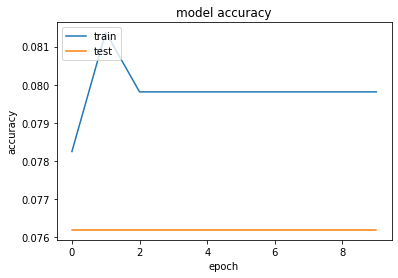

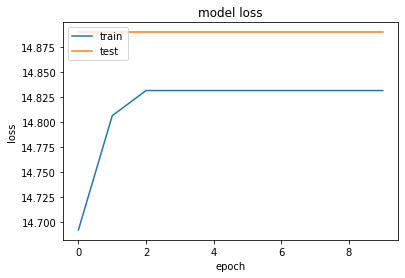

19/19 [==============================] - 4s 218ms/step
Test evaluation:
19/19 [==============================] - 5s 234ms/step - loss: 15.1649 - accuracy: 0.0591
[15.164875984191895, 0.059139784425497055]
% of correct brand in the first 3 positions:
25
0.13440860215053763
% of brand predicted with percentage >= 0.25
0.05913978494623656
% of brand predicted with percentage >= 0.5
0.05913978494623656
% of brand predicted with percentage >= 0.75
0.05913978494623656
Matriz de confusión:


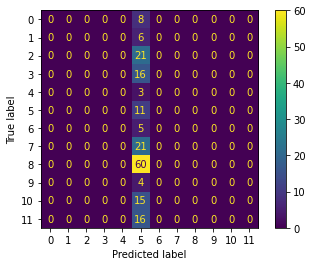

In [227]:
model_test27=executeModelData(False, True, True, True, 10, shoes_train3, shoes_test3, shoes_val3, df_shoe_brand3,num_classes3)

 
Training model with aumentation:True, gray:True, binary:True, crop:True and epochs = 10
Epoch 1/10
64/64 [==============================] - 74s 1s/step - loss: 13.7955 - accuracy: 0.1362 - val_loss: 14.2760 - val_accuracy: 0.1143
Epoch 2/10
64/64 [==============================] - 70s 1s/step - loss: 13.7218 - accuracy: 0.1487 - val_loss: 14.2760 - val_accuracy: 0.1143
Epoch 3/10
64/64 [==============================] - 70s 1s/step - loss: 13.7011 - accuracy: 0.1487 - val_loss: 14.2760 - val_accuracy: 0.1143
Epoch 4/10
64/64 [==============================] - 70s 1s/step - loss: 13.7128 - accuracy: 0.1487 - val_loss: 14.2760 - val_accuracy: 0.1143
Epoch 5/10
64/64 [==============================] - 70s 1s/step - loss: 13.6966 - accuracy: 0.1502 - val_loss: 14.2760 - val_accuracy: 0.1143
Epoch 6/10
64/64 [==============================] - 70s 1s/step - loss: 13.7470 - accuracy: 0.1471 - val_loss: 14.2760 - val_accuracy: 0.1143
Epoch 7/10
64/64 [==============================] - 70s 1s

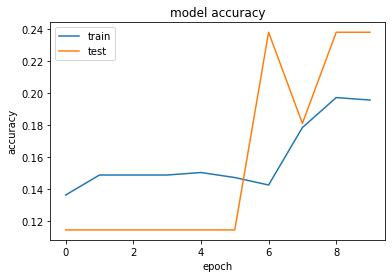

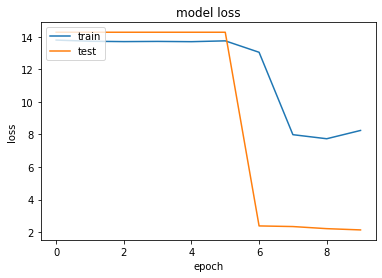

19/19 [==============================] - 5s 247ms/step
Test evaluation:
19/19 [==============================] - 5s 248ms/step - loss: 2.1736 - accuracy: 0.2204
[2.173585891723633, 0.22043010592460632]
% of correct brand in the first 3 positions:
108
0.5806451612903226
% of brand predicted with percentage >= 0.25
0.22043010752688172
% of brand predicted with percentage >= 0.5
0.0
% of brand predicted with percentage >= 0.75
0.0
Matriz de confusión:


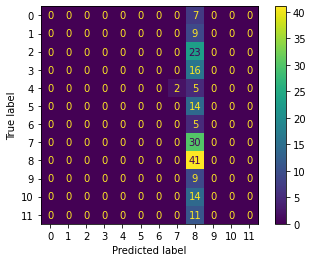

In [60]:
model_test28=executeModelData(True, True, True, True, 10, shoes_train3, shoes_test3, shoes_val3, df_shoe_brand3,num_classes3)

In [61]:
num_classes2, df_shoe_brand2,shoes_train2, shoes_test2, shoes_val2 = returnDataByMinSample(2)

             x   y
0       Adidas  12
6        Asics  13
10      Brooks   2
12    Champion   3
15    Converse   7
21        Ecco   2
30        Keen   3
32    Namuhana   2
33  Newbalance   4
34        Nike  24
39    Prospecs   2
42     Saucony   6
44     Shoopen   3
46    Skechers   8
49       Sorel   2
50      Sperry   7
53         T2R   2
54        Teva   3
57        Vans   2
Brands with at least 2 samples: 19
Brands with only 1 register: 40
(1070, 3)


 
Training model with aumentation:False, gray:False, binary:False, crop:False and epochs = 10
Epoch 1/10
74/74 [==============================] - 86s 1s/step - loss: 2.7749 - accuracy: 0.1590 - val_loss: 2.7197 - val_accuracy: 0.2333
Epoch 2/10
74/74 [==============================] - 85s 1s/step - loss: 2.7336 - accuracy: 0.2065 - val_loss: 2.6323 - val_accuracy: 0.2333
Epoch 3/10
74/74 [==============================] - 86s 1s/step - loss: 2.7062 - accuracy: 0.1957 - val_loss: 2.6405 - val_accuracy: 0.2333
Epoch 4/10
74/74 [==============================] - 96s 1s/step - loss: 2.6724 - accuracy: 0.1970 - val_loss: 2.6279 - val_accuracy: 0.2333
Epoch 5/10
74/74 [==============================] - 91s 1s/step - loss: 2.6554 - accuracy: 0.1957 - val_loss: 2.6329 - val_accuracy: 0.2333
Epoch 6/10
74/74 [==============================] - 88s 1s/step - loss: 2.6408 - accuracy: 0.2065 - val_loss: 2.6398 - val_accuracy: 0.2333
Epoch 7/10
74/74 [==============================] - 89s 1s/step - 

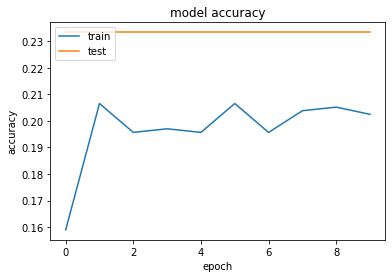

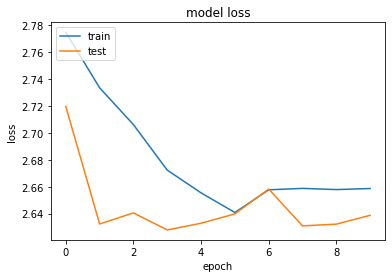

22/22 [==============================] - 6s 251ms/step
Test evaluation:
22/22 [==============================] - 7s 299ms/step - loss: 2.5919 - accuracy: 0.2617
[2.59185528755188, 0.2616822421550751]
% of correct brand in the first 3 positions:
102
0.4766355140186916
% of brand predicted with percentage >= 0.25
0.0
% of brand predicted with percentage >= 0.5
0.0
% of brand predicted with percentage >= 0.75
0.0
Matriz de confusión:


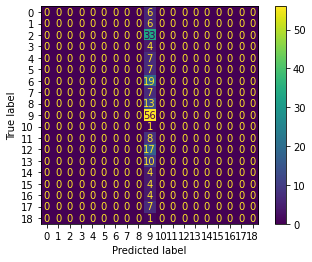

In [230]:
model_test29=executeModelData(False, False, False, False, 10, shoes_train2, shoes_test2, shoes_val2, df_shoe_brand2,num_classes2)

 
Training model with aumentation:True, gray:False, binary:False, crop:False and epochs = 10
Epoch 1/10
74/74 [==============================] - 91s 1s/step - loss: 3.1273 - accuracy: 0.1644 - val_loss: 2.8141 - val_accuracy: 0.2250
Epoch 2/10
74/74 [==============================] - 88s 1s/step - loss: 2.6989 - accuracy: 0.1780 - val_loss: 2.8321 - val_accuracy: 0.2250
Epoch 3/10
74/74 [==============================] - 88s 1s/step - loss: 2.6204 - accuracy: 0.1807 - val_loss: 4.7316 - val_accuracy: 0.2250
Epoch 4/10
74/74 [==============================] - 89s 1s/step - loss: 2.5055 - accuracy: 0.2188 - val_loss: 5.2323 - val_accuracy: 0.2250
Epoch 5/10
74/74 [==============================] - 88s 1s/step - loss: 2.4087 - accuracy: 0.2446 - val_loss: 6.6873 - val_accuracy: 0.1417
Epoch 6/10
74/74 [==============================] - 88s 1s/step - loss: 2.1812 - accuracy: 0.3247 - val_loss: 6.5034 - val_accuracy: 0.1417
Epoch 7/10
74/74 [==============================] - 89s 1s/step - l

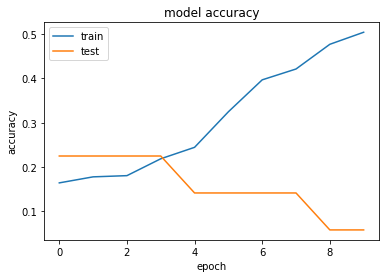

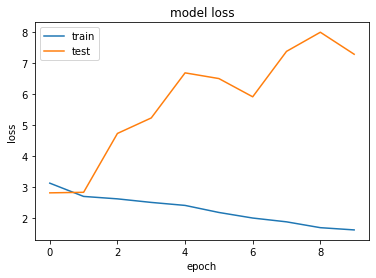

22/22 [==============================] - 6s 266ms/step
Test evaluation:
22/22 [==============================] - 6s 267ms/step - loss: 8.3252 - accuracy: 0.0280
[8.325196266174316, 0.028037382289767265]
% of correct brand in the first 3 positions:
69
0.32242990654205606
% of brand predicted with percentage >= 0.25
0.32242990654205606
% of brand predicted with percentage >= 0.5
0.0
% of brand predicted with percentage >= 0.75
0.0
Matriz de confusión:


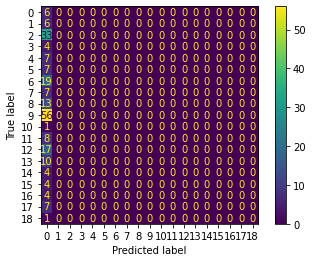

In [62]:
model_test30=executeModelData(True, False, False, False, 10, shoes_train2, shoes_test2, shoes_val2, df_shoe_brand2,num_classes2)

 
Training model with aumentation:False, gray:True, binary:True, crop:True and epochs = 10
Epoch 1/10
74/74 [==============================] - 83s 1s/step - loss: 3.5222 - accuracy: 0.1766 - val_loss: 2.5816 - val_accuracy: 0.2917
Epoch 2/10
74/74 [==============================] - 85s 1s/step - loss: 2.0134 - accuracy: 0.3736 - val_loss: 2.0762 - val_accuracy: 0.3417
Epoch 3/10
74/74 [==============================] - 88s 1s/step - loss: 1.2148 - accuracy: 0.6359 - val_loss: 1.5886 - val_accuracy: 0.4917
Epoch 4/10
74/74 [==============================] - 78s 1s/step - loss: 0.8268 - accuracy: 0.7283 - val_loss: 1.4501 - val_accuracy: 0.6083
Epoch 5/10
74/74 [==============================] - 81s 1s/step - loss: 0.5385 - accuracy: 0.8505 - val_loss: 1.5785 - val_accuracy: 0.5833
Epoch 6/10
74/74 [==============================] - 85s 1s/step - loss: 0.3236 - accuracy: 0.9062 - val_loss: 1.4453 - val_accuracy: 0.6417
Epoch 7/10
74/74 [==============================] - 76s 1s/step - los

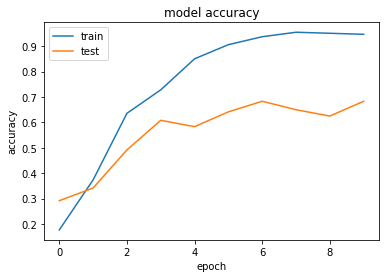

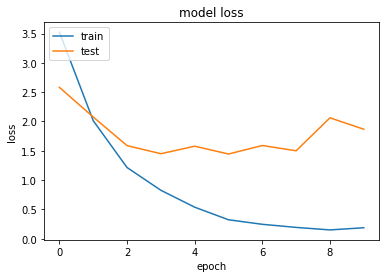

22/22 [==============================] - 5s 232ms/step
Test evaluation:
22/22 [==============================] - 6s 276ms/step - loss: 1.3484 - accuracy: 0.7009
[1.3483635187149048, 0.7009345889091492]
% of correct brand in the first 3 positions:
196
0.9158878504672897
% of brand predicted with percentage >= 0.25
0.1542056074766355
% of brand predicted with percentage >= 0.5
0.1542056074766355
% of brand predicted with percentage >= 0.75
0.1542056074766355
Matriz de confusión:


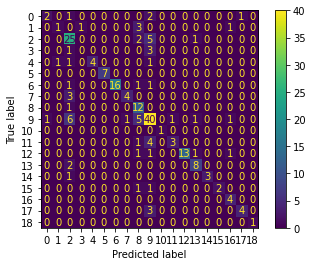

In [232]:
model_test31=executeModelData(False, True, True, True, 10, shoes_train2, shoes_test2, shoes_val2, df_shoe_brand2,num_classes2)

 
Training model with aumentation:True, gray:True, binary:True, crop:True and epochs = 10
Epoch 1/10
74/74 [==============================] - 83s 1s/step - loss: 8.8096 - accuracy: 0.1413 - val_loss: 2.5498 - val_accuracy: 0.2250
Epoch 2/10
74/74 [==============================] - 82s 1s/step - loss: 7.8674 - accuracy: 0.1753 - val_loss: 2.6580 - val_accuracy: 0.2250
Epoch 3/10
74/74 [==============================] - 82s 1s/step - loss: 7.5274 - accuracy: 0.1889 - val_loss: 2.6154 - val_accuracy: 0.2250
Epoch 4/10
74/74 [==============================] - 82s 1s/step - loss: 7.2148 - accuracy: 0.1753 - val_loss: 2.7495 - val_accuracy: 0.0917
Epoch 5/10
74/74 [==============================] - 82s 1s/step - loss: 7.2358 - accuracy: 0.1427 - val_loss: 2.6391 - val_accuracy: 0.1333
Epoch 6/10
74/74 [==============================] - 81s 1s/step - loss: 7.3436 - accuracy: 0.1386 - val_loss: 2.6498 - val_accuracy: 0.2250
Epoch 7/10
74/74 [==============================] - 82s 1s/step - loss

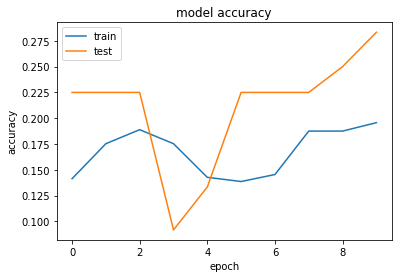

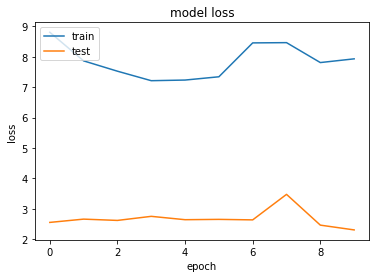

22/22 [==============================] - 6s 251ms/step
Test evaluation:
22/22 [==============================] - 6s 267ms/step - loss: 2.3681 - accuracy: 0.2477
[2.368114471435547, 0.24766355752944946]
% of correct brand in the first 3 positions:
98
0.45794392523364486
% of brand predicted with percentage >= 0.25
0.0
% of brand predicted with percentage >= 0.5
0.0
% of brand predicted with percentage >= 0.75
0.0
Matriz de confusión:


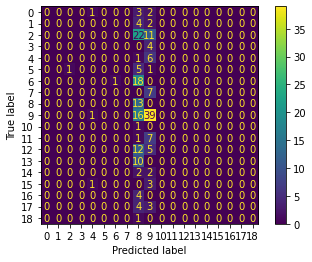

In [63]:
model_test32=executeModelData(True, True, True, True, 10, shoes_train2, shoes_test2, shoes_val2, df_shoe_brand2,num_classes2)

In [64]:
num_classes1, df_shoe_brand1,shoes_train1, shoes_test1, shoes_val1 = returnDataByMinSample(1)

                 x   y
0           Adidas  12
1         Airspeed   1
2          Airwalk   1
3             Aldo   1
4   American Eagle   1
5          Arizona   1
6            Asics  13
7             BAGO   1
8             BASS   1
9      Birkenstock   1
10          Brooks   2
11     CalvinKlain   1
12        Champion   3
13          Clarks   1
14        Columbus   1
15        Converse   7
16          Cooeli   1
17   Court classic   1
18          Dansko   1
19      Deer Stags   1
20         Dockers   1
21            Ecco   2
22         Elcanto   1
23      Fadedglory   1
24          Feiyue   1
25            Fila   1
26     G.H.Bass&Co   1
27            Guho   1
28         HeyBear   1
29         K-swiss   1
30            Keen   3
31          Landya   1
32        Namuhana   2
33      Newbalance   4
34            Nike  24
35        Ninewest   1
37              OP   1
38            Ofem   1
39        Prospecs   2
40            Puma   1
41           Robin   1
42         Saucony   6
43         

<ipython-input-15-6f4ddfca829a>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_shoe_brand['factor_brand'] = pd.Categorical(pd.factorize(df_shoe_brand['y'])[0].astype(np.float32))


 
Training model with aumentation:False, gray:False, binary:False, crop:False and epochs = 10
Epoch 1/10
102/102 [==============================] - 136s 1s/step - loss: 3.8670 - accuracy: 0.1424 - val_loss: 3.5780 - val_accuracy: 0.1758
Epoch 2/10
102/102 [==============================] - 220s 2s/step - loss: 3.6487 - accuracy: 0.1365 - val_loss: 3.5589 - val_accuracy: 0.1758
Epoch 3/10
102/102 [==============================] - 217s 2s/step - loss: 3.6568 - accuracy: 0.1583 - val_loss: 3.5024 - val_accuracy: 0.1758
Epoch 4/10
102/102 [==============================] - 212s 2s/step - loss: 3.6437 - accuracy: 0.1523 - val_loss: 3.5332 - val_accuracy: 0.1758
Epoch 5/10
102/102 [==============================] - 200s 2s/step - loss: 3.5711 - accuracy: 0.1503 - val_loss: 3.6305 - val_accuracy: 0.1758
Epoch 6/10
102/102 [==============================] - 286s 3s/step - loss: 3.5915 - accuracy: 0.1543 - val_loss: 3.5670 - val_accuracy: 0.1758
Epoch 7/10
102/102 [============================

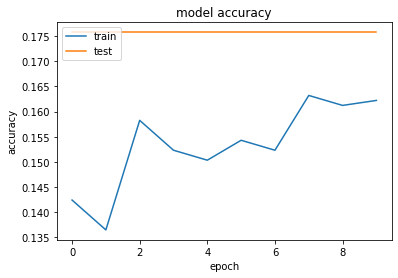

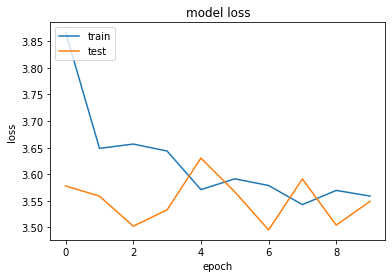

30/30 [==============================] - 15s 489ms/step
Test evaluation:
30/30 [==============================] - 16s 530ms/step - loss: 3.6018 - accuracy: 0.1565
[3.601834774017334, 0.15646257996559143]
% of correct brand in the first 3 positions:
98
0.3333333333333333
% of brand predicted with percentage >= 0.25
0.0
% of brand predicted with percentage >= 0.5
0.0
% of brand predicted with percentage >= 0.75
0.0


In [239]:
model_test33=executeModelData(False, False, False, False, 10, shoes_train1, shoes_test1, shoes_val1, df_shoe_brand1,num_classes1)

 
Training model with aumentation:True, gray:False, binary:False, crop:False and epochs = 10
Epoch 1/10
102/102 [==============================] - 126s 1s/step - loss: 4.6684 - accuracy: 0.1177 - val_loss: 3.5402 - val_accuracy: 0.1636
Epoch 2/10
102/102 [==============================] - 122s 1s/step - loss: 3.6103 - accuracy: 0.1454 - val_loss: 3.9533 - val_accuracy: 0.1636
Epoch 3/10
102/102 [==============================] - 121s 1s/step - loss: 3.4582 - accuracy: 0.1583 - val_loss: 4.9559 - val_accuracy: 0.1636
Epoch 4/10
102/102 [==============================] - 122s 1s/step - loss: 3.3429 - accuracy: 0.1790 - val_loss: 6.4668 - val_accuracy: 0.1636
Epoch 5/10
102/102 [==============================] - 122s 1s/step - loss: 3.1782 - accuracy: 0.2018 - val_loss: 6.1674 - val_accuracy: 0.1636
Epoch 6/10
102/102 [==============================] - 122s 1s/step - loss: 3.0340 - accuracy: 0.2334 - val_loss: 8.7387 - val_accuracy: 0.1636
Epoch 7/10
102/102 [=============================

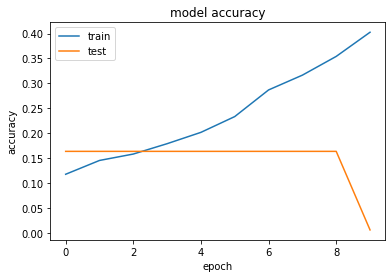

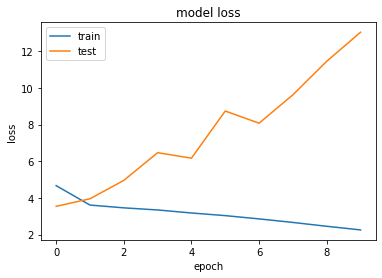

30/30 [==============================] - 8s 269ms/step
Test evaluation:
30/30 [==============================] - 8s 275ms/step - loss: 13.3836 - accuracy: 0.0102
[13.38359546661377, 0.010204081423580647]
% of correct brand in the first 3 positions:
53
0.18027210884353742
% of brand predicted with percentage >= 0.25
0.01020408163265306
% of brand predicted with percentage >= 0.5
0.01020408163265306
% of brand predicted with percentage >= 0.75
0.01020408163265306


In [65]:
model_test34=executeModelData(True, False, False, False, 10, shoes_train1, shoes_test1, shoes_val1, df_shoe_brand1,num_classes1)

 
Training model with aumentation:False, gray:True, binary:True, crop:True and epochs = 10
Epoch 1/10
102/102 [==============================] - 155s 2s/step - loss: 4.7010 - accuracy: 0.0762 - val_loss: 3.7318 - val_accuracy: 0.1758
Epoch 2/10
102/102 [==============================] - 156s 2s/step - loss: 3.6134 - accuracy: 0.1454 - val_loss: 3.2858 - val_accuracy: 0.1818
Epoch 3/10
102/102 [==============================] - 151s 1s/step - loss: 3.2100 - accuracy: 0.2127 - val_loss: 3.0592 - val_accuracy: 0.2182
Epoch 4/10
102/102 [==============================] - 152s 1s/step - loss: 2.6628 - accuracy: 0.3136 - val_loss: 2.7814 - val_accuracy: 0.3333
Epoch 5/10
102/102 [==============================] - 152s 1s/step - loss: 2.1699 - accuracy: 0.4045 - val_loss: 2.2784 - val_accuracy: 0.3939
Epoch 6/10
102/102 [==============================] - 152s 1s/step - loss: 1.7935 - accuracy: 0.4768 - val_loss: 2.0763 - val_accuracy: 0.4424
Epoch 7/10
102/102 [==============================]

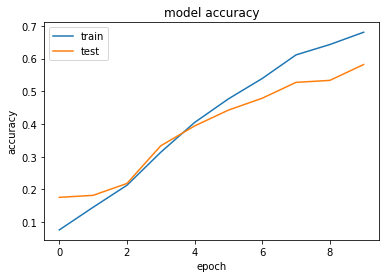

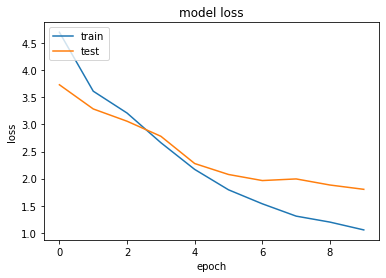

30/30 [==============================] - 14s 442ms/step
Test evaluation:
30/30 [==============================] - 13s 439ms/step - loss: 1.8061 - accuracy: 0.5374
[1.8061199188232422, 0.5374149680137634]
% of correct brand in the first 3 positions:
223
0.7585034013605442
% of brand predicted with percentage >= 0.25
0.1564625850340136
% of brand predicted with percentage >= 0.5
0.1564625850340136
% of brand predicted with percentage >= 0.75
0.1564625850340136


In [241]:
model_test35=executeModelData(False, True, True, True, 10, shoes_train1, shoes_test1, shoes_val1, df_shoe_brand1,num_classes1)

 
Training model with aumentation:True, gray:True, binary:True, crop:True and epochs = 10
Epoch 1/10
102/102 [==============================] - 114s 1s/step - loss: 9.8988 - accuracy: 0.0752 - val_loss: 4.1699 - val_accuracy: 0.0061
Epoch 2/10
102/102 [==============================] - 112s 1s/step - loss: 5.5382 - accuracy: 0.1256 - val_loss: 4.0087 - val_accuracy: 0.1636
Epoch 3/10
102/102 [==============================] - 111s 1s/step - loss: 4.0720 - accuracy: 0.1632 - val_loss: 3.9656 - val_accuracy: 0.1636
Epoch 4/10
102/102 [==============================] - 112s 1s/step - loss: 3.9427 - accuracy: 0.1642 - val_loss: 3.9279 - val_accuracy: 0.1636
Epoch 5/10
102/102 [==============================] - 113s 1s/step - loss: 3.9043 - accuracy: 0.1642 - val_loss: 3.8921 - val_accuracy: 0.1636
Epoch 6/10
102/102 [==============================] - 112s 1s/step - loss: 3.8691 - accuracy: 0.1642 - val_loss: 3.8602 - val_accuracy: 0.1636
Epoch 7/10
102/102 [==============================] 

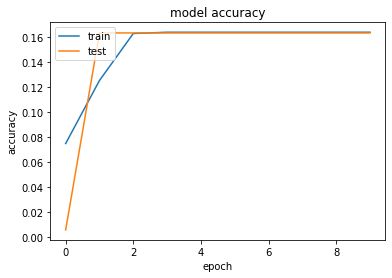

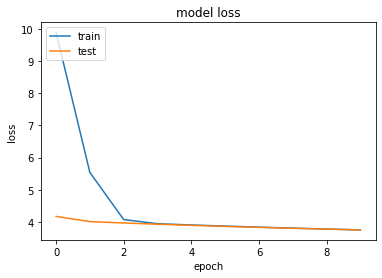

30/30 [==============================] - 8s 272ms/step
Test evaluation:
30/30 [==============================] - 8s 272ms/step - loss: 3.7887 - accuracy: 0.1599
[3.7886502742767334, 0.15986394882202148]
% of correct brand in the first 3 positions:
91
0.30952380952380953
% of brand predicted with percentage >= 0.25
0.0
% of brand predicted with percentage >= 0.5
0.0
% of brand predicted with percentage >= 0.75
0.0


In [66]:
model_test36=executeModelData(True, True, True, True, 10, shoes_train1, shoes_test1, shoes_val1, df_shoe_brand1,num_classes1)

In [67]:
num_classes10, df_shoe_brand10,shoes_train10, shoes_test10, shoes_val10 = returnDataByMinSample(10)

         x   y
0   Adidas  12
6    Asics  13
34    Nike  24
Brands with at least 10 samples: 3
Brands with only 1 register: 56
(490, 3)


 
Training model with aumentation:False, gray:False, binary:False, crop:False and epochs = 10
Epoch 1/10
34/34 [==============================] - 44s 1s/step - loss: 1.0982 - accuracy: 0.4570 - val_loss: 1.0913 - val_accuracy: 0.4182
Epoch 2/10
34/34 [==============================] - 41s 1s/step - loss: 1.0792 - accuracy: 0.4777 - val_loss: 1.0857 - val_accuracy: 0.4182
Epoch 3/10
34/34 [==============================] - 41s 1s/step - loss: 1.0707 - accuracy: 0.4777 - val_loss: 1.0827 - val_accuracy: 0.4182
Epoch 4/10
34/34 [==============================] - 37s 1s/step - loss: 1.0614 - accuracy: 0.4777 - val_loss: 1.0825 - val_accuracy: 0.4182
Epoch 5/10
34/34 [==============================] - 39s 1s/step - loss: 1.0576 - accuracy: 0.4777 - val_loss: 1.0842 - val_accuracy: 0.4182
Epoch 6/10
34/34 [==============================] - 44s 1s/step - loss: 1.0572 - accuracy: 0.4777 - val_loss: 1.0861 - val_accuracy: 0.4182
Epoch 7/10
34/34 [==============================] - 45s 1s/step - 

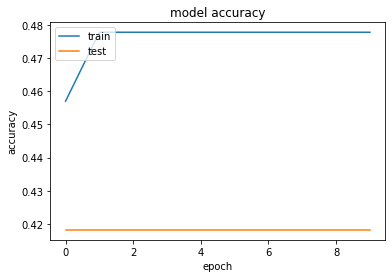

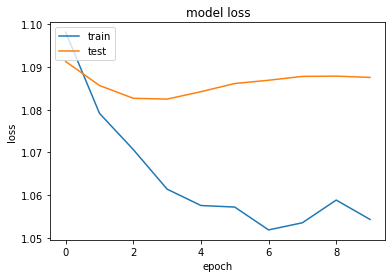

10/10 [==============================] - 3s 285ms/step
Test evaluation:
10/10 [==============================] - 3s 291ms/step - loss: 1.0016 - accuracy: 0.5714
[1.0015724897384644, 0.5714285969734192]
% of correct brand in the first 3 positions:
98
1.0
% of brand predicted with percentage >= 0.25
1.0
% of brand predicted with percentage >= 0.5
0.0
% of brand predicted with percentage >= 0.75
0.0
Matriz de confusión:


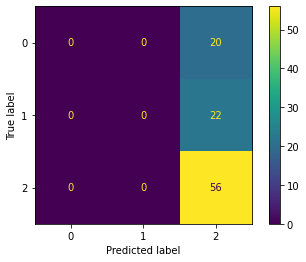

In [244]:
model_test37=executeModelData(False, False, False, False, 10, shoes_train10, shoes_test10, shoes_val10, df_shoe_brand10,num_classes10)

 
Training model with aumentation:True, gray:False, binary:False, crop:False and epochs = 10
Epoch 1/10
34/34 [==============================] - 43s 1s/step - loss: 7.9205 - accuracy: 0.4955 - val_loss: 8.2056 - val_accuracy: 0.4909
Epoch 2/10
34/34 [==============================] - 41s 1s/step - loss: 8.0830 - accuracy: 0.4985 - val_loss: 8.2056 - val_accuracy: 0.4909
Epoch 3/10
34/34 [==============================] - 41s 1s/step - loss: 8.0830 - accuracy: 0.4985 - val_loss: 8.2056 - val_accuracy: 0.4909
Epoch 4/10
34/34 [==============================] - 41s 1s/step - loss: 8.0830 - accuracy: 0.4985 - val_loss: 8.2056 - val_accuracy: 0.4909
Epoch 5/10
34/34 [==============================] - 41s 1s/step - loss: 8.0830 - accuracy: 0.4985 - val_loss: 8.2056 - val_accuracy: 0.4909
Epoch 6/10
34/34 [==============================] - 41s 1s/step - loss: 8.0830 - accuracy: 0.4985 - val_loss: 8.2056 - val_accuracy: 0.4909
Epoch 7/10
34/34 [==============================] - 41s 1s/step - l

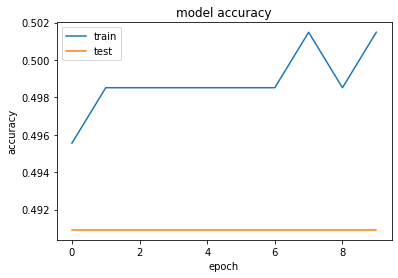

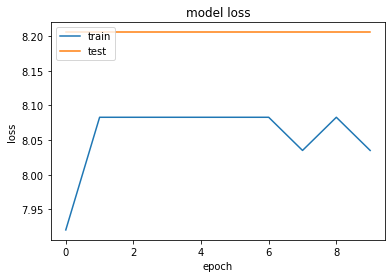

10/10 [==============================] - 3s 247ms/step
Test evaluation:
10/10 [==============================] - 3s 266ms/step - loss: 8.7169 - accuracy: 0.4592
[8.71692943572998, 0.4591836631298065]
% of correct brand in the first 3 positions:
98
1.0
% of brand predicted with percentage >= 0.25
0.45918367346938777
% of brand predicted with percentage >= 0.5
0.45918367346938777
% of brand predicted with percentage >= 0.75
0.45918367346938777
Matriz de confusión:


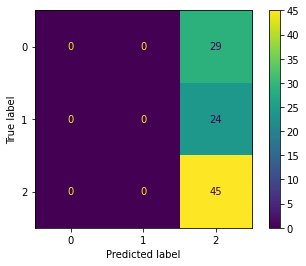

In [68]:
model_test38=executeModelData(True, False, False, False, 10, shoes_train10, shoes_test10, shoes_val10, df_shoe_brand10,num_classes10)

 
Training model with aumentation:False, gray:True, binary:True, crop:True and epochs = 10
Epoch 1/10
34/34 [==============================] - 41s 1s/step - loss: 2.7961 - accuracy: 0.4421 - val_loss: 1.0735 - val_accuracy: 0.4182
Epoch 2/10
34/34 [==============================] - 42s 1s/step - loss: 0.9298 - accuracy: 0.5460 - val_loss: 0.9274 - val_accuracy: 0.6182
Epoch 3/10
34/34 [==============================] - 40s 1s/step - loss: 0.6826 - accuracy: 0.6944 - val_loss: 0.5198 - val_accuracy: 0.7636
Epoch 4/10
34/34 [==============================] - 39s 1s/step - loss: 0.4502 - accuracy: 0.8131 - val_loss: 0.4233 - val_accuracy: 0.8364
Epoch 5/10
34/34 [==============================] - 42s 1s/step - loss: 0.3470 - accuracy: 0.8813 - val_loss: 0.5179 - val_accuracy: 0.8182
Epoch 6/10
34/34 [==============================] - 39s 1s/step - loss: 0.2452 - accuracy: 0.9139 - val_loss: 0.6282 - val_accuracy: 0.8364
Epoch 7/10
34/34 [==============================] - 40s 1s/step - los

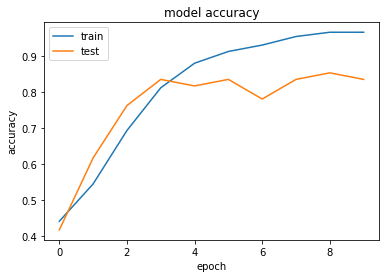

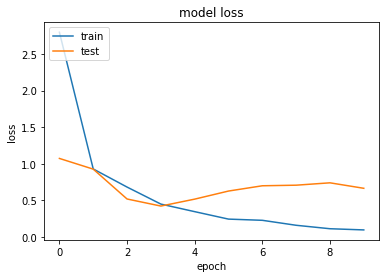

10/10 [==============================] - 3s 257ms/step
Test evaluation:
10/10 [==============================] - 3s 281ms/step - loss: 0.9397 - accuracy: 0.7653
[0.9397358298301697, 0.7653061151504517]
% of correct brand in the first 3 positions:
98
1.0
% of brand predicted with percentage >= 0.25
0.5714285714285714
% of brand predicted with percentage >= 0.5
0.5714285714285714
% of brand predicted with percentage >= 0.75
0.5714285714285714
Matriz de confusión:


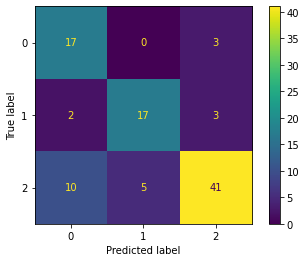

In [246]:
model_test39=executeModelData(False, True, True, True, 10, shoes_train10, shoes_test10, shoes_val10, df_shoe_brand10,num_classes10)

 
Training model with aumentation:True, gray:True, binary:True, crop:True and epochs = 10
Epoch 1/10
34/34 [==============================] - 39s 1s/step - loss: 11.7713 - accuracy: 0.2522 - val_loss: 12.3084 - val_accuracy: 0.2364
Epoch 2/10
34/34 [==============================] - 38s 1s/step - loss: 11.9092 - accuracy: 0.2611 - val_loss: 12.3084 - val_accuracy: 0.2364
Epoch 3/10
34/34 [==============================] - 38s 1s/step - loss: 11.9092 - accuracy: 0.2611 - val_loss: 12.3084 - val_accuracy: 0.2364
Epoch 4/10
34/34 [==============================] - 38s 1s/step - loss: 11.9092 - accuracy: 0.2611 - val_loss: 12.3084 - val_accuracy: 0.2364
Epoch 5/10
34/34 [==============================] - 37s 1s/step - loss: 11.9092 - accuracy: 0.2611 - val_loss: 12.3084 - val_accuracy: 0.2364
Epoch 6/10
34/34 [==============================] - 38s 1s/step - loss: 11.9092 - accuracy: 0.2611 - val_loss: 12.3084 - val_accuracy: 0.2364
Epoch 7/10
34/34 [==============================] - 37s 1s

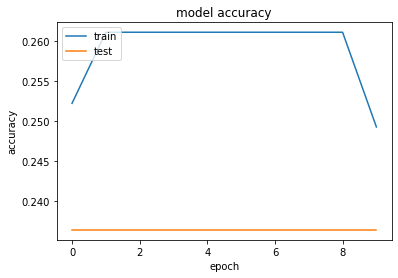

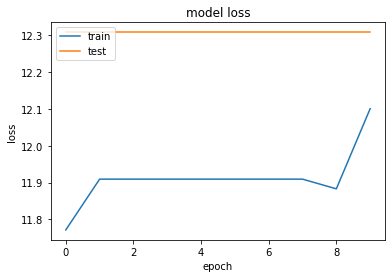

10/10 [==============================] - 3s 234ms/step
Test evaluation:
10/10 [==============================] - 3s 244ms/step - loss: 11.3485 - accuracy: 0.2959
[11.348454475402832, 0.29591837525367737]
% of correct brand in the first 3 positions:
98
1.0
% of brand predicted with percentage >= 0.25
0.29591836734693877
% of brand predicted with percentage >= 0.5
0.29591836734693877
% of brand predicted with percentage >= 0.75
0.29591836734693877
Matriz de confusión:


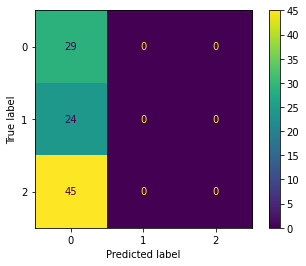

In [69]:
model_test40=executeModelData(True, True, True, True, 10, shoes_train10, shoes_test10, shoes_val10, df_shoe_brand10,num_classes10)

## Variaciones en las capas

En este apartado se analizan los resultados al utilizar más o menos capas en el modelo para comprender la utilizadad de cada una de ellas.

Para estos experimentos se usan las imágenes con tamaño 280x832, epoch = 10,  preprocesado a blanco y negro sin espacios en blanco y con o sin aumentación. En total, dos experimentos por variación. Las variaciones se van a realizar eliminando una o varias capas del modelo presentado como solución para ver si influye en el resultado.

Ls capas utilizadas son las siguientes:

- Conv2D  
- MaxPooling2D  
- Flatten  
- Dense  relu
- Dense  softmax
- Dropout  




In [70]:
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten, Softmax, Rescaling, Dropout
import tensorflow as tf
import cv2

def createCustomModel(n, withActivation='relu',withMax = True, extraLayers = True, withFlatten=True, withDense=True,
                      withDropout = True , dropout_value = 0.5, withSoftmax =True):
    
    print("Activation: "+withActivation+", maxPooling2D: "+str(withMax)+
         ", extraLayers: "+str(extraLayers)+", withFlatten: "+ str(withFlatten)+
         ", withDense: "+str(withDense)+", withDropout: "+str(withDropout)+
         ", Dropout value: "+str(dropout_value)+", withSoftmax: "+str(withSoftmax))
    
    modelC = models.Sequential()
    modelC.add(Conv2D(16, 3, padding='same', activation=withActivation, input_shape=(280,832,1)))
    #if withMax == True:
    modelC.add(MaxPooling2D())
    if extraLayers == True:
        modelC.add(Conv2D(32, 3, padding='same', activation=withActivation))
        if withMax == True:
            modelC.add(MaxPooling2D())
        modelC.add(Conv2D(64, 3, padding='same', activation=withActivation)) 
        if withMax == True:
            modelC.add(MaxPooling2D())
                     
    if withFlatten == True:
        modelC.add(Flatten()) 
    if withDense==True:
        modelC.add(Dense(128, activation = "relu"))
    if withDropout == True:
        modelC.add(Dropout(dropout_value))
    if withSoftmax == True:
        modelC.add(Dense(n, activation='softmax'))
    if withFlatten==True:
        modelC.add(Flatten())   
                     
    return modelC
    


In [71]:
def testCustomModel(n, withActivation='relu',withMax = True, extraLayers = True, withFlatten=True, withDense=True,
                      withDropout = True , dropout_value = 0.5, withSoftmax =True, aumentation = False):
    print("Aumentation: "+str(aumentation))
    start = datetime.now()
    
    model = createCustomModel(num_classes,withActivation, withMax, extraLayers, withFlatten, withDense, 
                              withDropout, dropout_value, withSoftmax)
    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
    
    trainGenerator=DataGenerator2dFootwear(shoes_train['X'].tolist(),df_shoe_brand, aumentation, "images/", True, True, True)
    testGenerator=DataGenerator2dFootwear(shoes_test['X'].tolist(),df_shoe_brand, False, "images/", True, True, True)
    valGenerator=DataGenerator2dFootwear(shoes_val['X'].tolist(),df_shoe_brand, False, "images/", True, True, True)
    model.summary()
    history = model.fit(trainGenerator,validation_data=valGenerator, epochs=10)

    end= datetime.now()
    print("Time used: "+str(end-start))
    
    plot_history(history)
    
    checkModel(model, testGenerator, shoes_test, num_classes)
    return history, model

### Sin Dropout 


Activation: relu, maxPooling2D: True, extraLayers: True, withFlatten: True, withDense: True, withDropout: False, Dropout value: 0.5, withSoftmax: True
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_51 (Conv2D)          (None, 280, 832, 16)      160       
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 140, 416, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_52 (Conv2D)          (None, 140, 416, 32)      4640      
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 70, 208, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_53 (Conv2D)          (None

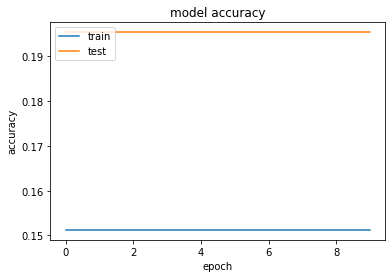

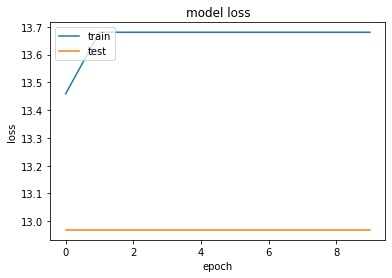

16/16 [==============================] - 6s 360ms/step
Test evaluation:
16/16 [==============================] - 7s 416ms/step - loss: 13.7108 - accuracy: 0.1494
[13.710846900939941, 0.14935064315795898]
% of correct brand in the first 3 positions:
59
0.38311688311688313
% of brand predicted with percentage >= 0.25
0.14935064935064934
% of brand predicted with percentage >= 0.5
0.14935064935064934
% of brand predicted with percentage >= 0.75
0.14935064935064934
Matriz de confusión:


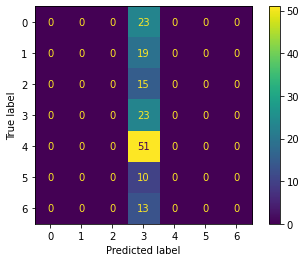

In [76]:

model_1 = testCustomModel(num_classes,'relu', True, True, True, True, False)


Aumentation: True
Activation: relu, maxPooling2D: True, extraLayers: True, withFlatten: True, withDense: True, withDropout: False, Dropout value: 0.5, withSoftmax: True
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_63 (Conv2D)          (None, 280, 832, 16)      160       
                                                                 
 max_pooling2d_63 (MaxPoolin  (None, 140, 416, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_64 (Conv2D)          (None, 140, 416, 32)      4640      
                                                                 
 max_pooling2d_64 (MaxPoolin  (None, 70, 208, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_65 (Conv

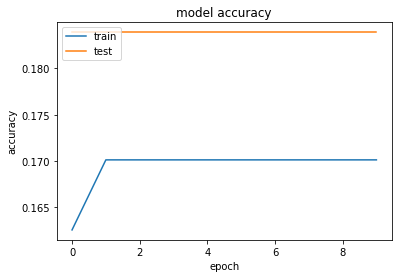

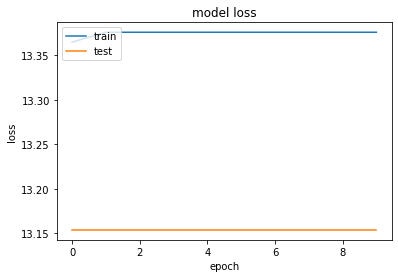

16/16 [==============================] - 4s 239ms/step
Test evaluation:
16/16 [==============================] - 4s 246ms/step - loss: 13.6062 - accuracy: 0.1558
[13.606184959411621, 0.15584415197372437]
% of correct brand in the first 3 positions:
66
0.42857142857142855
% of brand predicted with percentage >= 0.25
0.15584415584415584
% of brand predicted with percentage >= 0.5
0.15584415584415584
% of brand predicted with percentage >= 0.75
0.15584415584415584
Matriz de confusión:


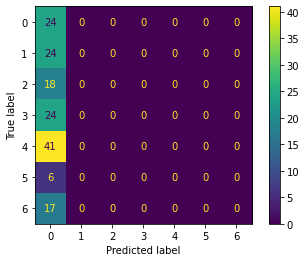

In [72]:

model_1a = testCustomModel(num_classes,'relu', True, True, True, True, False, 0.5 , True, True)


### Dropout del 0.1

Activation: relu, maxPooling2D: True, extraLayers: True, withFlatten: True, withDense: True, withDropout: True, Dropout value: 0.1, withSoftmax: True
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_57 (Conv2D)          (None, 280, 832, 16)      160       
                                                                 
 max_pooling2d_47 (MaxPoolin  (None, 140, 416, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_58 (Conv2D)          (None, 140, 416, 32)      4640      
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 70, 208, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_59 (Conv2D)          (None,

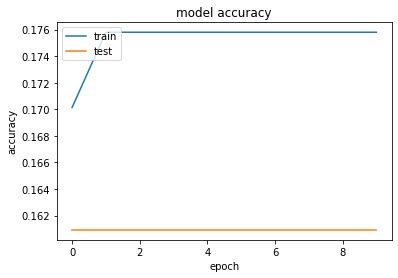

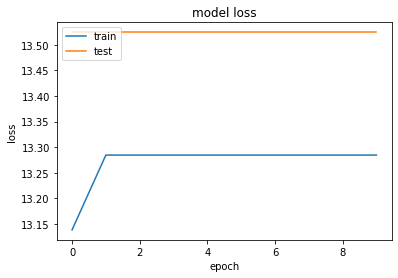

16/16 [==============================] - 5s 296ms/step
Test evaluation:
16/16 [==============================] - 5s 283ms/step - loss: 13.7108 - accuracy: 0.1494
[13.710848808288574, 0.14935064315795898]
% of correct brand in the first 3 positions:
57
0.37012987012987014
% of brand predicted with percentage >= 0.25
0.14935064935064934
% of brand predicted with percentage >= 0.5
0.14935064935064934
% of brand predicted with percentage >= 0.75
0.14935064935064934
Matriz de confusión:


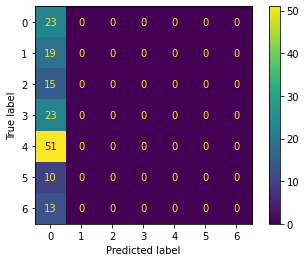

In [78]:
model_2 = testCustomModel(num_classes,'relu', True, True, True, True, True, 0.1)


Aumentation: True
Activation: relu, maxPooling2D: True, extraLayers: True, withFlatten: True, withDense: True, withDropout: True, Dropout value: 0.1, withSoftmax: True
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_66 (Conv2D)          (None, 280, 832, 16)      160       
                                                                 
 max_pooling2d_66 (MaxPoolin  (None, 140, 416, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_67 (Conv2D)          (None, 140, 416, 32)      4640      
                                                                 
 max_pooling2d_67 (MaxPoolin  (None, 70, 208, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_68 (Conv2

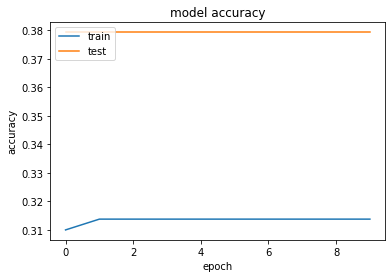

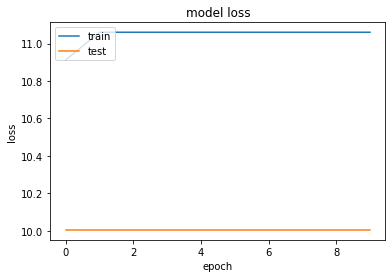

16/16 [==============================] - 4s 241ms/step
Test evaluation:
16/16 [==============================] - 4s 246ms/step - loss: 11.8269 - accuracy: 0.2662
[11.826915740966797, 0.26623377203941345]
% of correct brand in the first 3 positions:
89
0.577922077922078
% of brand predicted with percentage >= 0.25
0.2662337662337662
% of brand predicted with percentage >= 0.5
0.2662337662337662
% of brand predicted with percentage >= 0.75
0.2662337662337662
Matriz de confusión:


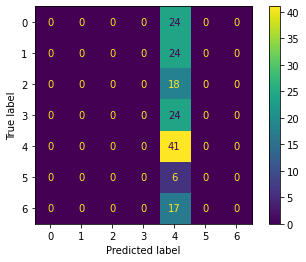

In [73]:
model_2a = testCustomModel(num_classes,'relu', True, True, True, True, True, 0.1 , True, True)

### Dropout del 0.8

Activation: relu, maxPooling2D: True, extraLayers: True, withFlatten: True, withDense: True, withDropout: True, Dropout value: 0.8, withSoftmax: True
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_63 (Conv2D)          (None, 280, 832, 16)      160       
                                                                 
 max_pooling2d_53 (MaxPoolin  (None, 140, 416, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_64 (Conv2D)          (None, 140, 416, 32)      4640      
                                                                 
 max_pooling2d_54 (MaxPoolin  (None, 70, 208, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_65 (Conv2D)          (None,

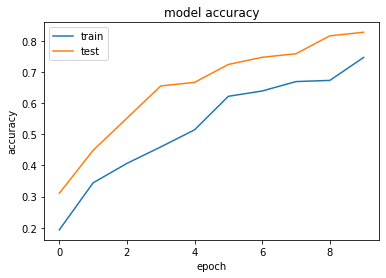

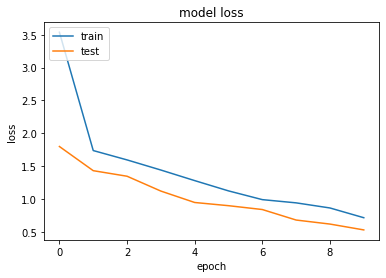

16/16 [==============================] - 4s 250ms/step
Test evaluation:
16/16 [==============================] - 4s 259ms/step - loss: 0.6280 - accuracy: 0.7468
[0.628024697303772, 0.7467532753944397]
% of correct brand in the first 3 positions:
149
0.9675324675324676
% of brand predicted with percentage >= 0.25
0.14935064935064934
% of brand predicted with percentage >= 0.5
0.14935064935064934
% of brand predicted with percentage >= 0.75
0.14935064935064934
Matriz de confusión:


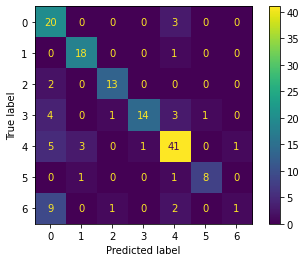

In [80]:
model_3 = testCustomModel(num_classes,'relu', True, True, True, True, True, 0.8)

Aumentation: True
Activation: relu, maxPooling2D: True, extraLayers: True, withFlatten: True, withDense: True, withDropout: True, Dropout value: 0.1, withSoftmax: True
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_69 (Conv2D)          (None, 280, 832, 16)      160       
                                                                 
 max_pooling2d_69 (MaxPoolin  (None, 140, 416, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_70 (Conv2D)          (None, 140, 416, 32)      4640      
                                                                 
 max_pooling2d_70 (MaxPoolin  (None, 70, 208, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_71 (Conv2

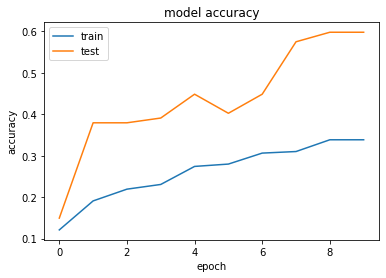

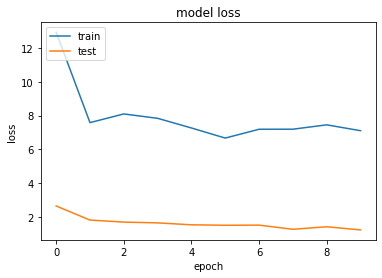

16/16 [==============================] - 4s 258ms/step
Test evaluation:
16/16 [==============================] - 4s 268ms/step - loss: 1.6604 - accuracy: 0.3831
[1.6603707075119019, 0.38311687111854553]
% of correct brand in the first 3 positions:
121
0.7857142857142857
% of brand predicted with percentage >= 0.25
0.3116883116883117
% of brand predicted with percentage >= 0.5
0.0
% of brand predicted with percentage >= 0.75
0.0
Matriz de confusión:


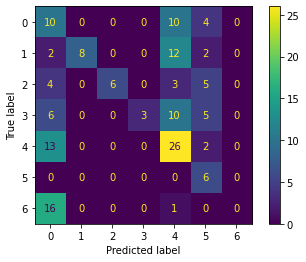

In [74]:
model_3a = testCustomModel(num_classes,'relu', True, True, True, True, True, 0.1 , True, True)

### Sin Softmax 

Activation: relu, maxPooling2D: True, extraLayers: True, withFlatten: True, withDense: True, withDropout: True, Dropout value: 0.5, withSoftmax: False
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_74 (Conv2D)          (None, 280, 832, 16)      160       
                                                                 
 max_pooling2d_64 (MaxPoolin  (None, 140, 416, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_75 (Conv2D)          (None, 140, 416, 32)      4640      
                                                                 
 max_pooling2d_65 (MaxPoolin  (None, 70, 208, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_76 (Conv2D)          (None

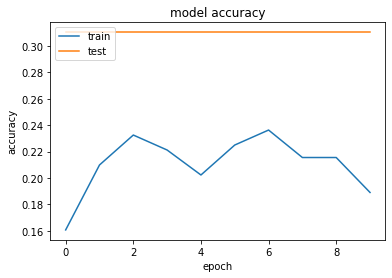

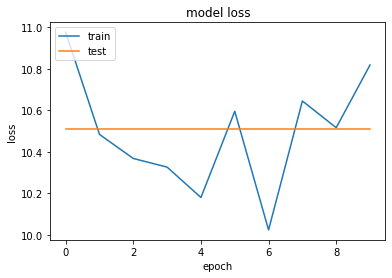

16/16 [==============================] - 3s 204ms/step
Test evaluation:
16/16 [==============================] - 3s 209ms/step - loss: 10.1128 - accuracy: 0.3312
[10.11281967163086, 0.3311688303947449]
% of correct brand in the first 3 positions:
87
0.564935064935065
% of brand predicted with percentage >= 0.25
0.4155844155844156
% of brand predicted with percentage >= 0.5
0.4155844155844156
% of brand predicted with percentage >= 0.75
0.4155844155844156
Matriz de confusión:


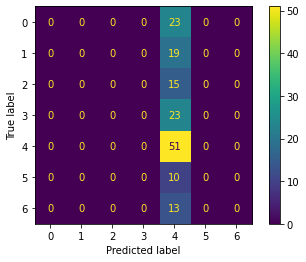

In [86]:
model_4 = testCustomModel(num_classes,'relu', True, True, True, True, True, 0.5, False)

Aumentation: True
Activation: relu, maxPooling2D: True, extraLayers: True, withFlatten: True, withDense: True, withDropout: True, Dropout value: 0.5, withSoftmax: False
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_72 (Conv2D)          (None, 280, 832, 16)      160       
                                                                 
 max_pooling2d_72 (MaxPoolin  (None, 140, 416, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_73 (Conv2D)          (None, 140, 416, 32)      4640      
                                                                 
 max_pooling2d_73 (MaxPoolin  (None, 70, 208, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_74 (Conv

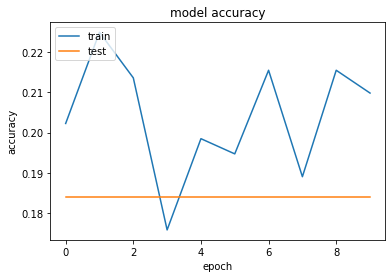

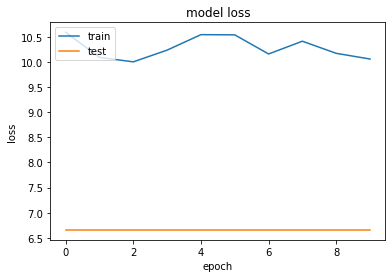

16/16 [==============================] - 4s 207ms/step
Test evaluation:
16/16 [==============================] - 3s 205ms/step - loss: 9.7857 - accuracy: 0.1558
[9.785683631896973, 0.15584415197372437]
% of correct brand in the first 3 positions:
71
0.461038961038961
% of brand predicted with percentage >= 0.25
0.461038961038961
% of brand predicted with percentage >= 0.5
0.461038961038961
% of brand predicted with percentage >= 0.75
0.461038961038961
Matriz de confusión:


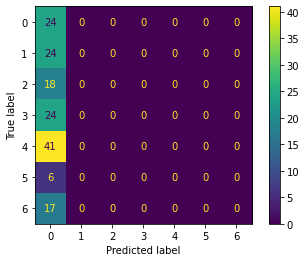

In [75]:
model_4a = testCustomModel(num_classes,'relu', True, True, True, True, True, 0.5, False, True)

### Sin extra Layers

Activation: relu, maxPooling2D: True, extraLayers: False, withFlatten: True, withDense: True, withDropout: True, Dropout value: 0.5, withSoftmax: True
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_72 (Conv2D)          (None, 280, 832, 16)      160       
                                                                 
 max_pooling2d_62 (MaxPoolin  (None, 140, 416, 16)     0         
 g2D)                                                            
                                                                 
 flatten_40 (Flatten)        (None, 931840)            0         
                                                                 
 dense_44 (Dense)            (None, 128)               119275648 
                                                                 
 dropout_17 (Dropout)        (None, 128)               0         
                                  

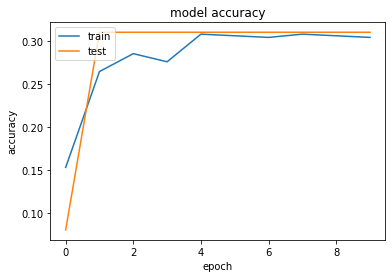

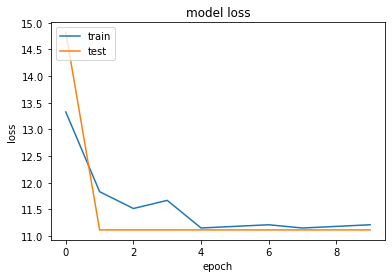

16/16 [==============================] - 4s 215ms/step
Test evaluation:
16/16 [==============================] - 4s 211ms/step - loss: 10.7803 - accuracy: 0.3312
[10.780284881591797, 0.3311688303947449]
% of correct brand in the first 3 positions:
93
0.6038961038961039
% of brand predicted with percentage >= 0.25
0.33116883116883117
% of brand predicted with percentage >= 0.5
0.33116883116883117
% of brand predicted with percentage >= 0.75
0.33116883116883117
Matriz de confusión:


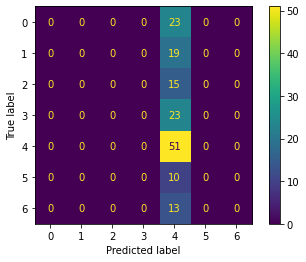

In [83]:
model_5 = testCustomModel(num_classes,'relu', True, False)

Aumentation: True
Activation: relu, maxPooling2D: True, extraLayers: False, withFlatten: True, withDense: True, withDropout: True, Dropout value: 0.5, withSoftmax: True
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_75 (Conv2D)          (None, 280, 832, 16)      160       
                                                                 
 max_pooling2d_75 (MaxPoolin  (None, 140, 416, 16)     0         
 g2D)                                                            
                                                                 
 flatten_50 (Flatten)        (None, 931840)            0         
                                                                 
 dense_49 (Dense)            (None, 128)               119275648 
                                                                 
 dropout_24 (Dropout)        (None, 128)               0         
                

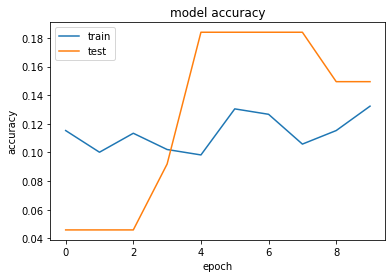

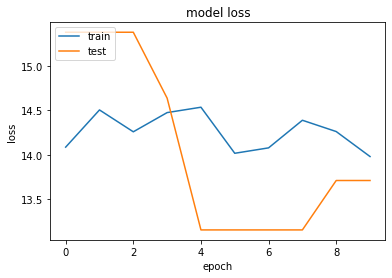

16/16 [==============================] - 3s 178ms/step
Test evaluation:
16/16 [==============================] - 3s 181ms/step - loss: 13.6062 - accuracy: 0.1558
[13.606184959411621, 0.15584415197372437]
% of correct brand in the first 3 positions:
72
0.4675324675324675
% of brand predicted with percentage >= 0.25
0.15584415584415584
% of brand predicted with percentage >= 0.5
0.15584415584415584
% of brand predicted with percentage >= 0.75
0.15584415584415584
Matriz de confusión:


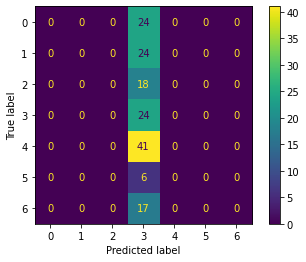

In [76]:
#sinextra con aumentación
model_5a=testCustomModel(num_classes, 'relu',True, False,True, True, True, 0.5,True, True)

### Sin Dense

Activation: relu, maxPooling2D: True, extraLayers: True, withFlatten: True, withDense: False, withDropout: True, Dropout value: 0.5, withSoftmax: True
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_69 (Conv2D)          (None, 280, 832, 16)      160       
                                                                 
 max_pooling2d_59 (MaxPoolin  (None, 140, 416, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_70 (Conv2D)          (None, 140, 416, 32)      4640      
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 70, 208, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_71 (Conv2D)          (None

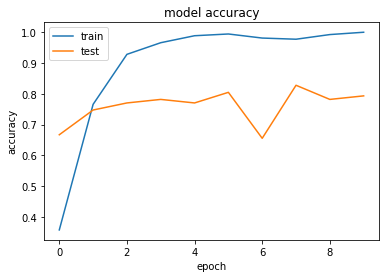

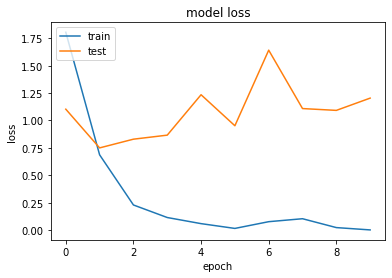

16/16 [==============================] - 5s 282ms/step
Test evaluation:
16/16 [==============================] - 5s 306ms/step - loss: 0.7921 - accuracy: 0.8052
[0.7921475768089294, 0.8051947951316833]
% of correct brand in the first 3 positions:
149
0.9675324675324676
% of brand predicted with percentage >= 0.25
0.14935064935064934
% of brand predicted with percentage >= 0.5
0.14935064935064934
% of brand predicted with percentage >= 0.75
0.14935064935064934
Matriz de confusión:


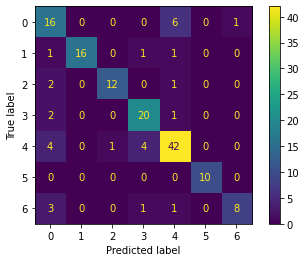

In [82]:
model_6 = testCustomModel(num_classes,'relu', True, True, True, False)

Aumentation: True
Activation: relu, maxPooling2D: True, extraLayers: True, withFlatten: True, withDense: False, withDropout: True, Dropout value: 0.5, withSoftmax: True
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_76 (Conv2D)          (None, 280, 832, 16)      160       
                                                                 
 max_pooling2d_76 (MaxPoolin  (None, 140, 416, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_77 (Conv2D)          (None, 140, 416, 32)      4640      
                                                                 
 max_pooling2d_77 (MaxPoolin  (None, 70, 208, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_78 (Conv

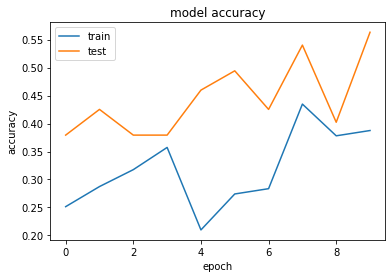

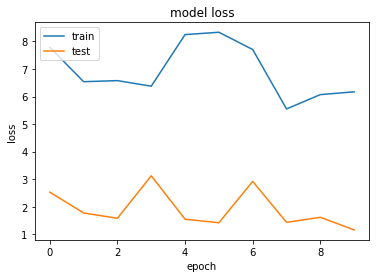

16/16 [==============================] - 3s 203ms/step
Test evaluation:
16/16 [==============================] - 3s 205ms/step - loss: 1.3660 - accuracy: 0.3896
[1.366049885749817, 0.3896103799343109]
% of correct brand in the first 3 positions:
122
0.7922077922077922
% of brand predicted with percentage >= 0.25
0.42207792207792205
% of brand predicted with percentage >= 0.5
0.0
% of brand predicted with percentage >= 0.75
0.0
Matriz de confusión:


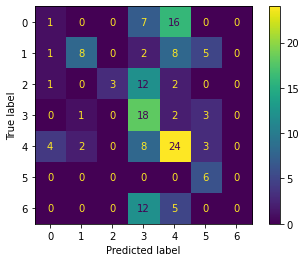

In [77]:
model_6a = testCustomModel(num_classes, 'relu',True, True, True, False, True, 0.5, True, True)

### Sin segunda capa Flatten



In [ ]:
model_7 = testCustomModel(num_classes,'relu', True, True, False) #error

In [ ]:
#model_7a = testCustomModel(num_classes, 'relu',True, True, False, True, True, 0.5, True, True)

### Sin MaxPooling

Activation: relu, maxPooling2D: False, extraLayers: True, withFlatten: True, withDense: True, withDropout: True, Dropout value: 0.5, withSoftmax: True
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 280, 832, 16)      160       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 140, 416, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 140, 416, 32)      4640      
                                                                 
 conv2d_32 (Conv2D)          (None, 140, 416, 64)      18496     
                                                                 
 flatten_14 (Flatten)        (None, 3727360)           0         
                                  

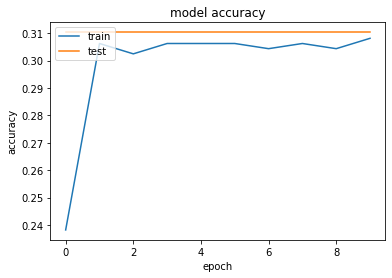

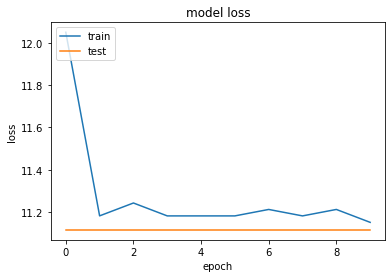

16/16 [==============================] - 7s 378ms/step
Test evaluation:
16/16 [==============================] - 7s 414ms/step - loss: 10.7803 - accuracy: 0.3312
[10.780284881591797, 0.3311688303947449]
% of correct brand in the first 3 positions:
93
0.6038961038961039
% of brand predicted with percentage >= 0.25
0.33116883116883117
% of brand predicted with percentage >= 0.5
0.33116883116883117
% of brand predicted with percentage >= 0.75
0.33116883116883117
Matriz de confusión:


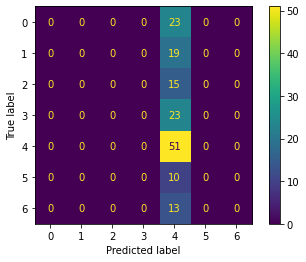

In [69]:
model_8 = testCustomModel(num_classes,'relu', False)

Aumentation: True
Activation: relu, maxPooling2D: False, extraLayers: True, withFlatten: True, withDense: True, withDropout: 0.5, Dropout value: True, withSoftmax: True
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_88 (Conv2D)          (None, 280, 832, 16)      160       
                                                                 
 max_pooling2d_88 (MaxPoolin  (None, 140, 416, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_89 (Conv2D)          (None, 140, 416, 32)      4640      
                                                                 
 conv2d_90 (Conv2D)          (None, 140, 416, 64)      18496     
                                                                 
 flatten_60 (Flatten)        (None, 3727360)           0         
                

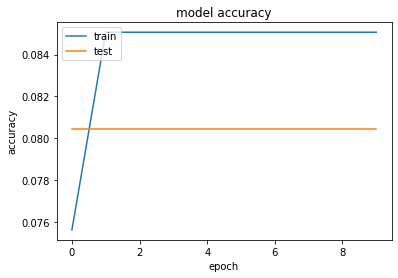

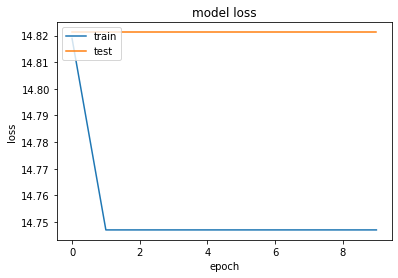

16/16 [==============================] - 7s 366ms/step
Test evaluation:
16/16 [==============================] - 6s 368ms/step - loss: 14.2342 - accuracy: 0.1169
[14.234162330627441, 0.11688311398029327]
% of correct brand in the first 3 positions:
66
0.42857142857142855
% of brand predicted with percentage >= 0.25
0.11688311688311688
% of brand predicted with percentage >= 0.5
0.11688311688311688
% of brand predicted with percentage >= 0.75
0.11688311688311688
Matriz de confusión:


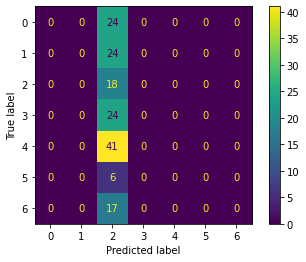

In [81]:
model_9a = testCustomModel(num_classes, 'relu', False, True, True, True, 0.5, True, True, True) #Falta pero tarda molt

### Modelo propuesto con diferentes valores de activación:

Activation: sigmoid, maxPooling2D: True, extraLayers: True, withFlatten: True, withDense: True, withDropout: True, Dropout value: 0.5, withSoftmax: True
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 280, 832, 16)      160       
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 140, 416, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 140, 416, 32)      4640      
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 70, 208, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (No

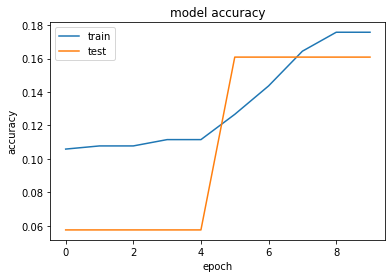

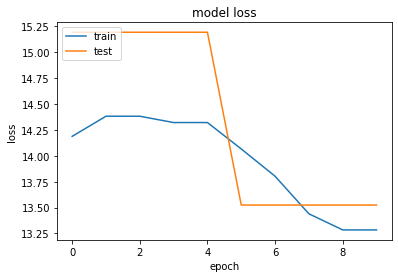

16/16 [==============================] - 4s 222ms/step
Test evaluation:
16/16 [==============================] - 4s 236ms/step - loss: 13.7108 - accuracy: 0.1494
[13.710848808288574, 0.14935064315795898]
% of correct brand in the first 3 positions:
57
0.37012987012987014
% of brand predicted with percentage >= 0.25
0.14935064935064934
% of brand predicted with percentage >= 0.5
0.14935064935064934
% of brand predicted with percentage >= 0.75
0.14935064935064934
Matriz de confusión:


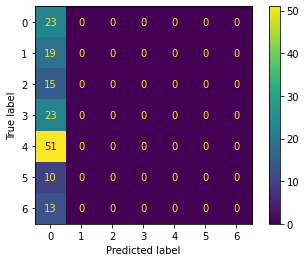

In [70]:
model_sigmoid = testCustomModel(num_classes, 'sigmoid')

Aumentation: False
Activation: sigmoid, maxPooling2D: True, extraLayers: True, withFlatten: True, withDense: True, withDropout: 0.5, Dropout value: True, withSoftmax: True
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_79 (Conv2D)          (None, 280, 832, 16)      160       
                                                                 
 max_pooling2d_79 (MaxPoolin  (None, 140, 416, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_80 (Conv2D)          (None, 140, 416, 32)      4640      
                                                                 
 max_pooling2d_80 (MaxPoolin  (None, 70, 208, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_81 (C

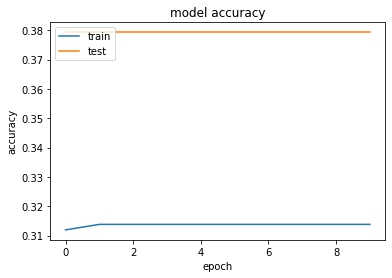

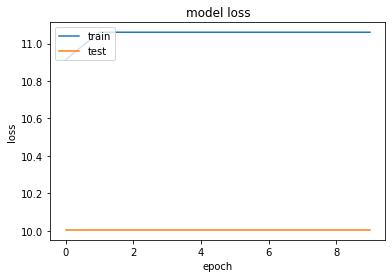

16/16 [==============================] - 4s 216ms/step
Test evaluation:
16/16 [==============================] - 4s 218ms/step - loss: 11.8269 - accuracy: 0.2662
[11.826915740966797, 0.26623377203941345]
% of correct brand in the first 3 positions:
89
0.577922077922078
% of brand predicted with percentage >= 0.25
0.2662337662337662
% of brand predicted with percentage >= 0.5
0.2662337662337662
% of brand predicted with percentage >= 0.75
0.2662337662337662
Matriz de confusión:


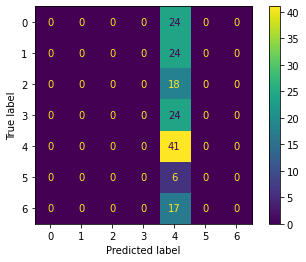

In [78]:
model_sigmoida = testCustomModel(num_classes, 'sigmoid', True, True, True, True, 0.5, True, True) 

Activation: tanh, maxPooling2D: True, extraLayers: True, withFlatten: True, withDense: True, withDropout: True, Dropout value: 0.5, withSoftmax: True
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 280, 832, 16)      160       
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 140, 416, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 140, 416, 32)      4640      
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 70, 208, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None,

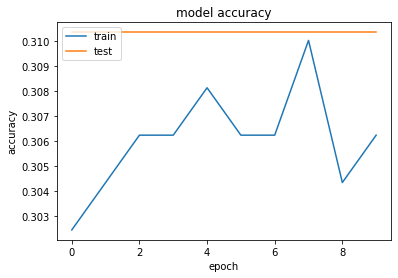

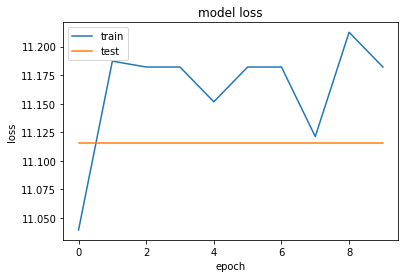

16/16 [==============================] - 4s 228ms/step
Test evaluation:
16/16 [==============================] - 4s 225ms/step - loss: 10.7803 - accuracy: 0.3312
[10.780284881591797, 0.3311688303947449]
% of correct brand in the first 3 positions:
93
0.6038961038961039
% of brand predicted with percentage >= 0.25
0.33116883116883117
% of brand predicted with percentage >= 0.5
0.33116883116883117
% of brand predicted with percentage >= 0.75
0.33116883116883117
Matriz de confusión:


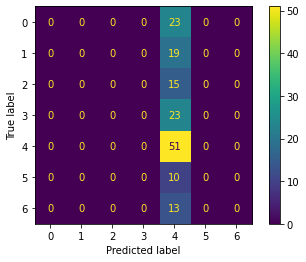

In [71]:
model_tanh=testCustomModel(num_classes, 'tanh')

Aumentation: False
Activation: tanh, maxPooling2D: True, extraLayers: True, withFlatten: True, withDense: True, withDropout: 0.5, Dropout value: True, withSoftmax: True
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_82 (Conv2D)          (None, 280, 832, 16)      160       
                                                                 
 max_pooling2d_82 (MaxPoolin  (None, 140, 416, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_83 (Conv2D)          (None, 140, 416, 32)      4640      
                                                                 
 max_pooling2d_83 (MaxPoolin  (None, 70, 208, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_84 (Conv

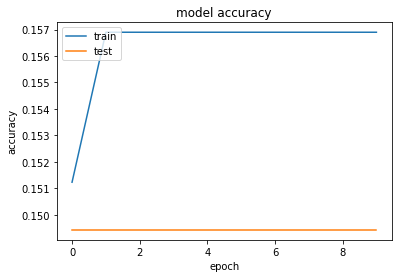

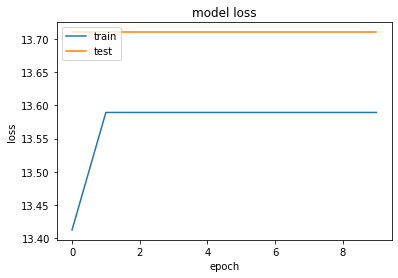

16/16 [==============================] - 4s 213ms/step
Test evaluation:
16/16 [==============================] - 4s 218ms/step - loss: 13.6062 - accuracy: 0.1558
[13.606184959411621, 0.15584415197372437]
% of correct brand in the first 3 positions:
72
0.4675324675324675
% of brand predicted with percentage >= 0.25
0.15584415584415584
% of brand predicted with percentage >= 0.5
0.15584415584415584
% of brand predicted with percentage >= 0.75
0.15584415584415584
Matriz de confusión:


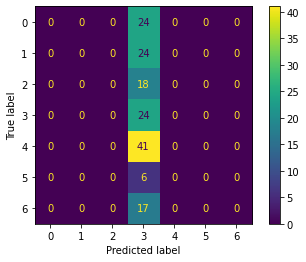

In [79]:
model_tanha = testCustomModel(num_classes, 'tanh', True, True, True, True, 0.5, True, True) 

Activation: relu, maxPooling2D: True, extraLayers: True, withFlatten: True, withDense: True, withDropout: 0.5, Dropout value: True, withSoftmax: True
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_95 (Conv2D)          (None, 280, 832, 16)      160       
                                                                 
 max_pooling2d_83 (MaxPoolin  (None, 140, 416, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_96 (Conv2D)          (None, 140, 416, 32)      4640      
                                                                 
 max_pooling2d_84 (MaxPoolin  (None, 70, 208, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_97 (Conv2D)          (None,

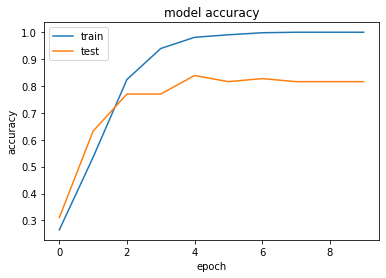

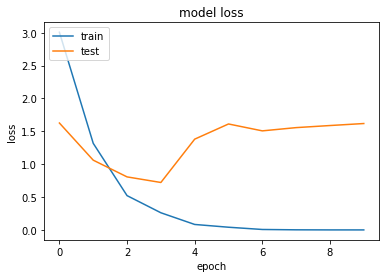

16/16 [==============================] - 5s 270ms/step
Test evaluation:
16/16 [==============================] - 4s 255ms/step - loss: 1.0065 - accuracy: 0.8247
[1.0065144300460815, 0.8246753215789795]
% of correct brand in the first 3 positions:
152
0.987012987012987
% of brand predicted with percentage >= 0.25
0.14935064935064934
% of brand predicted with percentage >= 0.5
0.14935064935064934
% of brand predicted with percentage >= 0.75
0.14935064935064934
Matriz de confusión:


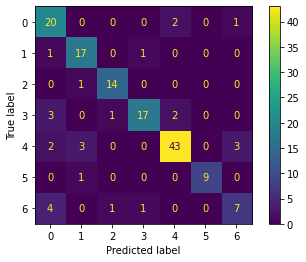

In [93]:
#sin eliminar nada:
model_complete = testCustomModel(num_classes, 'relu', True, True, True, True, 0.5, True) 

Aumentation: False
Activation: relu, maxPooling2D: True, extraLayers: True, withFlatten: True, withDense: True, withDropout: 0.5, Dropout value: True, withSoftmax: True
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_85 (Conv2D)          (None, 280, 832, 16)      160       
                                                                 
 max_pooling2d_85 (MaxPoolin  (None, 140, 416, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_86 (Conv2D)          (None, 140, 416, 32)      4640      
                                                                 
 max_pooling2d_86 (MaxPoolin  (None, 70, 208, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_87 (Conv

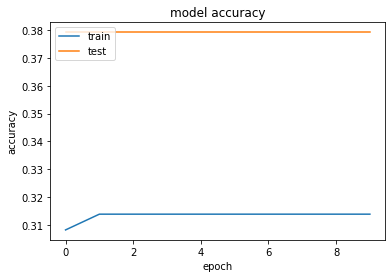

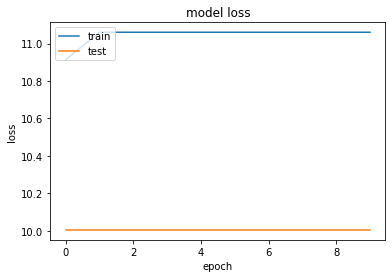

16/16 [==============================] - 4s 212ms/step
Test evaluation:
16/16 [==============================] - 3s 210ms/step - loss: 11.8269 - accuracy: 0.2662
[11.826915740966797, 0.26623377203941345]
% of correct brand in the first 3 positions:
89
0.577922077922078
% of brand predicted with percentage >= 0.25
0.2662337662337662
% of brand predicted with percentage >= 0.5
0.2662337662337662
% of brand predicted with percentage >= 0.75
0.2662337662337662
Matriz de confusión:


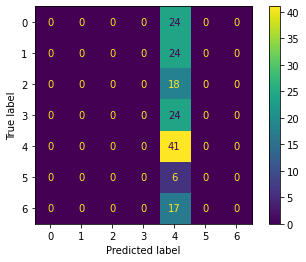

In [80]:
model_complete_a=testCustomModel(num_classes, 'relu', True, True, True, True, 0.5, True, True) 

### RestNet50

ResNet50 + capas

In [139]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50


modelPre3 = models.Sequential()
modelPre3.add(ResNet50(include_top=False, input_shape=(832, 280, 3), 
                   weights="imagenet", classes = num_classes, classifier_activation="softmax"))
modelPre3.add(Flatten())
modelPre3.add(Dense(512, activation='relu'))
modelPre3.add(BatchNormalization())
modelPre3.add(Dropout(0.5))
modelPre3.add(Dense(num_classes, activation='softmax'))
modelPre3.add(Flatten())



modelPre3.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 26, 9, 2048)       23587712  
                                                                 
 flatten_11 (Flatten)        (None, 479232)            0         
                                                                 
 dense_21 (Dense)            (None, 512)               245367296 
                                                                 
 batch_normalization_10 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dropout_12 (Dropout)        (None, 512)               0         
                                                                 
 dense_22 (Dense)            (None, 7)                 3591      
                                                     

In [140]:

modelPre3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [141]:
trainGeneratorPre3=DataGenerator2dFootwear(shoes_train['X'].tolist(),df_shoe_brand,False, "images/", False, False, False)
testGeneratorPre3=DataGenerator2dFootwear(shoes_test['X'].tolist(),df_shoe_brand,False, "images/", False, False, False)
valGeneratorPre3=DataGenerator2dFootwear(shoes_val['X'].tolist(),df_shoe_brand,False, "images/",False, False, False)



In [143]:
preHistory3 = modelPre3.fit(trainGeneratorPre3,validation_data=valGeneratorPre3, epochs=10)

53/53 [==============================] - 1821s 34s/step - loss: 1.2982 - accuracy: 0.6144 - val_loss: 11.6717 - val_accuracy: 0.2759


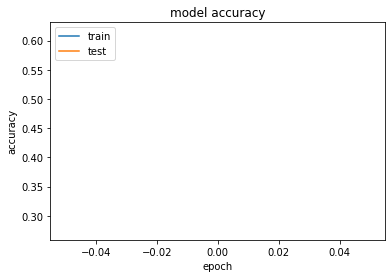

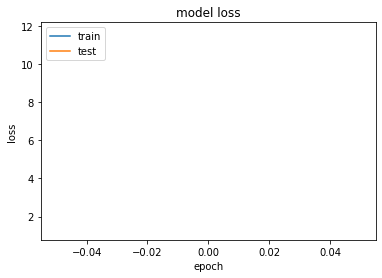

In [144]:
plot_history(preHistory3)

In [145]:
print(modelPre3.evaluate(testGeneratorPre3))

16/16 [==============================] - 66s 4s/step - loss: 11.0943 - accuracy: 0.3117
[11.094273567199707, 0.31168830394744873]


In [146]:
test = np.empty([280,832], dtype=int)

test = np.array([io.imread("images/"+p) for p in shoes_test.X.values])
pre_predicted_y3 = modelPre3.predict(test)

5/5 [==============================] - 68s 12s/step


[0. 0. 0. 0. 1. 0. 0.]
[4 0 1 2 3 5 6]


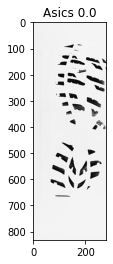

In [147]:
showResult(pre_predicted_y3[0],shoes_test.iloc[0], True)

In [152]:
checkAccuracyFirstPositions(pre_predicted_y3, shoes_test,3)

91
0.5909090909090909


In [ ]:
modelPre4 = models.Sequential()
modelPre4.add(ResNet50(include_top=False, input_shape=(832, 280, 3), 
                   weights="imagenet", classes = num_classes, classifier_activation="softmax"))
modelPre4.add(Flatten())

modelPre4.summary()

modelPre4.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

trainGeneratorPre4=DataGenerator2dFootwear(shoes_train['X'].tolist(),df_shoe_brand,False, "images/", False, False, False)
testGeneratorPre4=DataGenerator2dFootwear(shoes_test['X'].tolist(),df_shoe_brand,False, "images/", False, False, False)
valGeneratorPre4=DataGenerator2dFootwear(shoes_val['X'].tolist(),df_shoe_brand,False, "images/",False, False, False)



In [ ]:
preHistory4 = modelPre4.fit(trainGeneratorPre4,validation_data=valGeneratorPre4, epochs=10)

In [ ]:
print(modelPre4.evaluate(testGeneratorPre4))

In [ ]:
test = np.empty([280,832], dtype=int)

test = np.array([io.imread("images/"+p) for p in shoes_test.X.values])
pre_predicted_y4 = modelPre4.predict(test)



In [ ]:
checkAccuracyFirstPositions(pre_predicted_y4, shoes_test,1)

In [ ]:
checkAccuracyFirstPositions(pre_predicted_y4, shoes_test,3)

## Análisis de resultados

https://pypi.org/project/tabulate/
